# EAT Attribute-Supervised Anomaly Detection (End-to-End)

**Pipeline overview**
1. Discover dataset structure and **define attribute labels** (machine × section).
2. **Extract train features** with EAT; cache to speed up retries.
3. **Train attribute classifier** (CrossEntropy **or CosFace**). (Optional **LoRA** fine-tune if PEFT is available.)
4. **Extract test features**.
5. Build a **global PCA** on train features; fit **per-attribute Gaussian** stats (mean, covariance with ridge).
6. **Anomaly scoring** for each test sample = *min Mahalanobis distance* to any attribute group (optionally **fuse** with logit **energy**). 
7. **Report metrics** per machine: AUC and pAUC@0.1; print helpful diagnostics and render plots.

This notebook prints **progress logs**, **debug shapes**, and produces **plots** for each machine.

> _Tip:_ Set the configuration cell below before running all.

In [1]:
#@title 0) Configuration
from dataclasses import dataclass

@dataclass
class CFG:
    dataset_root: str = "./dataset_dev"  # path with subfolders per machine
    model_id: str = "local:data2vec-multi"
    sr: int = 16000
    target_length: int = 1024
    batch_size: int = 32
    seed: int = 42

    # Attribute classifier
    epochs: int = 100
    lr: float = 2e-4
    weight_decay: float = 1e-5
    grad_clip: float = 1.0
    warmup: float = 0.05
    use_cosface: bool = True
    cosface_s: float = 64.0
    cosface_m: float = 0.35
    balanced_sampler: bool = True
    class_weight_power: float = 1.0
    max_class_weight: float = 50.0
    sampler_num_samples_scale: float = 2.0

    # Pooling for EAT tokens
    pool_mode: str = "cls_only"  # one of: "cls_only", "mean_no_cls", "mean_with_cls"

    # Input feature normalization ablation
    norm_divisor: float = 2.0  # scales NORM_STD; previously fixed at 2.0

    # Optional LoRA
    use_lora: bool = True
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.10
    lora_last_n: int = 4 # was 8
    lora_lr: float = 5e-5
    lora_epochs: int = 10 # was 15
    lora_warmup: float = 0.1
    lora_grad_clip: float = 1.0
    lora_val_split: float = 0.1
    lora_early_stop: int = 5
    lora_targets: str = "qkv, proj, attnn, fc1"  # was "qkv, proj, att"
    lora_include_mlp_fc1: bool = False

    # Scoring / PCA-Gaussian
    pca_var: float = 0.98     # keep 98% variance
    ridge_lambda: float = 1e-3
    ridge_lambda_strong: float = 1e-2  # used for ill-conditioned/tied covariances
    cov_strategy: str = "auto"  # one of: "full", "diag", "tied", "auto"
    auto_cov_min_n: int = 5       # if group size < this, fallback
    auto_cov_cond_thr: float = 1e6  # if cond(S) exceeds, fallback
    auto_cov_fallback: str = "tied"  # one of: "tied" or "diag"

    # Optional fusion with energy from attribute head
    fuse_energy: bool = False  # fuse z(Mahalanobis) + alpha*z(-Energy)
    fuse_alpha: float = 1.0
    energy_temp: object = None  # None (no scaling), float > 0 (fixed T), or "auto" to learn on train

    results_dir: str = "./results_attr_supervised"

CFG = CFG()
print(CFG)


CFG(dataset_root='./dataset_dev', model_id='local:data2vec-multi', sr=16000, target_length=1024, batch_size=32, seed=42, epochs=100, lr=0.0002, weight_decay=1e-05, grad_clip=1.0, warmup=0.05, use_cosface=True, cosface_s=64.0, cosface_m=0.35, balanced_sampler=True, class_weight_power=1.0, max_class_weight=50.0, sampler_num_samples_scale=2.0, pool_mode='cls_only', norm_divisor=2.0, use_lora=True, lora_r=16, lora_alpha=32, lora_dropout=0.1, lora_last_n=4, lora_lr=5e-05, lora_epochs=10, lora_warmup=0.1, lora_grad_clip=1.0, lora_val_split=0.1, lora_early_stop=5, lora_targets='qkv, proj, attnn, fc1', lora_include_mlp_fc1=False, pca_var=0.98, ridge_lambda=0.001, ridge_lambda_strong=0.01, cov_strategy='auto', auto_cov_min_n=5, auto_cov_cond_thr=1000000.0, auto_cov_fallback='tied', fuse_energy=False, fuse_alpha=1.0, energy_temp=None, results_dir='./results_attr_supervised')


In [2]:
#@title 1) Imports, seeding, and helpers
import os, re, math, json, random, gc, time
from pathlib import Path
from datetime import datetime
from collections import Counter, defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
matplotlib.use('inline')  # Ensure inline backend is used

plt.rcParams["figure.figsize"] = (9,7)

def set_all_seeds(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_all_seeds(CFG.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# EAT extractor (adjust import path if needed)
import sys
sys.path.insert(0, '/home/sey87151/EAT_Clean')
from aed_torch_module_forest.models import Data2VecMultiModel
from v3_reporter import (
    NORM_MEAN,
    NORM_STD,
 )

# PEFT (optional)
try:
    from peft import LoraConfig, get_peft_model, TaskType
    PEFT_AVAILABLE = True
except Exception as e:
    print("[Info] PEFT not available:", e)
    PEFT_AVAILABLE = False

def ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)

RESULTS_DIR = Path(CFG.results_dir) / ("lora" if CFG.use_lora else "baseline")
ensure_dir(RESULTS_DIR)
LORA_STATE_PATH = RESULTS_DIR / "lora_backbone.pt"
LORA_META_PATH = RESULTS_DIR / "lora_meta.json"
DEBUG_PATH = RESULTS_DIR / "debug_trace.json"
FEATURE_EXTRACTOR = None
LORA_LOG = {}

def update_debug(tag: str, payload, append: bool = False):
    """Persist structured debug telemetry to disk."""
    try:
        if DEBUG_PATH.exists():
            with open(DEBUG_PATH) as f:
                store = json.load(f)
        else:
            store = {}
    except Exception:
        store = {}
    entry = {"timestamp": datetime.now().isoformat(), "data": payload}
    if append:
        store.setdefault(tag, []).append(entry)
    else:
        store[tag] = entry
    with open(DEBUG_PATH, "w") as f:
        json.dump(store, f, indent=2)
    return entry

def infer_anom_from_path(p: Path) -> int:
    s = str(p).lower()
    return 1 if ("anomaly" in s or "abnormal" in s) else 0

def infer_attribute_from_name(name: str) -> str:
    """Extract attribute from filename based on various patterns"""
    # Check for explicit "noAttribute" case
    if "noattribute" in name.lower():
        return "noAttribute"
    
    # Check for pattern like "pro_A", "pro_B", "n_B" etc.
    m1 = re.search(r"_(pro|n)_([A-Za-z])", name.lower())
    if m1:
        return f"{m1.group(1)}_{m1.group(2)}"
    
    # Check for pattern like "v1pat_(\d+)_v2pat_(\d+)"
    m2 = re.search(r"v1pat_(\d+)_v2pat_(\d+)", name.lower())
    if m2:
        return f"v1pat{m2.group(1)}_v2pat{m2.group(2)}"
    
    # Still extract section as fallback
    m3 = re.search(r"(section|sec|s)[-_]?(\d+)", name.lower())
    if m3:
        return f"sec{m3.group(2)}"
    
    return "default"

def list_machines(root: str):
    rootp = Path(root)
    return sorted([d.name for d in rootp.iterdir() if d.is_dir()])

print("Notebook start time:", "%s" % ("{:%Y-%m-%d %H:%M:%S}".format(__import__("datetime").datetime.now())))

Device: cuda


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Notebook start time: 2025-10-18 12:24:56


In [3]:
#@title 1.5) Load local EAT backbone (Data2VecMultiModel)
from typing import Any, Dict, List, Optional, Tuple
from collections import OrderedDict

MODEL_WEIGHTS_PATH = Path("EAT-base_epoch30_pt.pt")
if not MODEL_WEIGHTS_PATH.exists():
    raise FileNotFoundError(
        f"Expected weights at {MODEL_WEIGHTS_PATH} — please place the checkpoint in the workspace."
    )

MODEL_CONFIG: Dict[str, Any] = {
    "depth": 12 ,
    "embed_dim": 768,
    "num_heads": 12,
}

MODEL_SIGNATURE = {
    "model_id": CFG.model_id,
    "weights_path": str(MODEL_WEIGHTS_PATH.resolve()),
    "weights_mtime": float(MODEL_WEIGHTS_PATH.stat().st_mtime),
    "config": MODEL_CONFIG,
}

base_eat_model = Data2VecMultiModel.Data2VecMultiModel(**MODEL_CONFIG)
base_eat_model.eval()

checkpoint = torch.load(MODEL_WEIGHTS_PATH, map_location="cpu")
state_dict = checkpoint.get("model", checkpoint)
normalized_state_dict = {
    key.replace("model.", ""): value for key, value in state_dict.items()
}

missing_keys, unexpected_keys = base_eat_model.load_state_dict(normalized_state_dict, strict=False)
base_eat_model.to(device)

if missing_keys:
    print("[WARN] Missing parameters:")
    for key in missing_keys:
        print(f"  • {key}")
if unexpected_keys:
    print("[WARN] Unexpected checkpoint entries:")
    for key in unexpected_keys:
        print(f"  • {key}")

total_params = sum(p.numel() for p in base_eat_model.parameters())
trainable_params = sum(p.numel() for p in base_eat_model.parameters() if p.requires_grad)

BASE_EAT_STATE_DICT = OrderedDict(
    (k, v.detach().cpu()) for k, v in base_eat_model.state_dict().items()
)

class LocalEATFeatureExtractor:
    def __init__(
        self,
        model: torch.nn.Module,
        sr: int,
        target_length: int,
        train_mode: bool = False,
        pool_mode: str = "cls_only",
        device: Optional[torch.device] = None,
    ):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.sr = sr
        self.target_len = target_length
        self.pool_mode = pool_mode
        self.train_mode = train_mode
        if self.train_mode:
            self.model.train()
        else:
            self.model.eval()

    def _wav_to_fbank(self, wav: np.ndarray) -> Tuple[torch.Tensor, int]:
        w = torch.tensor(wav, dtype=torch.float32)
        if w.ndim != 1:
            w = w.view(-1)
        w = w - w.mean()
        fb = torchaudio.compliance.kaldi.fbank(
            w.unsqueeze(0),
            htk_compat=True,
            sample_frequency=self.sr,
            use_energy=False,
            window_type="hanning",
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10,
        )
        T_true = fb.size(0)
        if self.target_len is not None:
            if T_true < self.target_len:
                fb = F.pad(fb, (0, 0, 0, self.target_len - T_true))
            elif T_true > self.target_len:
                fb = fb[: self.target_len, :]
        fb = (fb - NORM_MEAN) / (NORM_STD * CFG.norm_divisor)
        length = min(T_true, self.target_len or T_true)
        return fb, length

    def _model_forward(self, features: torch.Tensor) -> torch.Tensor:
        if features.dim() == 4 and features.size(1) == 1:
            x = features[:, 0, :, :]
        elif features.dim() == 3:
            x = features
        else:
            raise ValueError(f"Unexpected feature shape: {features.shape}")
        x = x.to(self.device)
        seq = self.model(x)
        if seq.dim() == 4 and seq.size(1) == 1:
            seq = seq.squeeze(1)
        return seq

    def _masked_mean(self, seq: torch.Tensor, lengths: Optional[torch.Tensor], drop_cls: bool) -> torch.Tensor:
        lengths_adj: Optional[torch.Tensor] = None
        if lengths is not None:
            lengths_adj = lengths.to(seq.device)
            if drop_cls:
                lengths_adj = (lengths_adj - 1).clamp_min(1)
        if drop_cls and seq.size(1) >= 2:
            seq = seq[:, 1:, :]
        if lengths_adj is None:
            return seq.mean(dim=1)
        T = seq.size(1)
        mask = (torch.arange(T, device=seq.device)[None, :] < lengths_adj[:, None]).float().unsqueeze(-1)
        denom = mask.sum(1).clamp_min(1.0)
        return (seq * mask).sum(1) / denom

    @torch.no_grad()
    def encode_batch(self, wavs: List[np.ndarray]) -> np.ndarray:
        fb_list, lengths = [], []
        for w in wavs:
            fb, L = self._wav_to_fbank(w)
            fb_list.append(fb)
            lengths.append(L)
        x = torch.stack(fb_list, dim=0).to(self.device)
        lengths_t = torch.tensor(lengths, dtype=torch.long, device=self.device)
        seq = self._model_forward(x)
        if self.pool_mode == "cls_only" and seq.size(1) > 0:
            pooled = seq[:, 0, :]
        elif self.pool_mode == "mean_no_cls":
            pooled = self._masked_mean(seq, lengths_t, drop_cls=True)
        else:
            pooled = self._masked_mean(seq, lengths_t, drop_cls=False)
        return pooled.detach().cpu().numpy()

    def forward_cls(self, fbank_batch: torch.Tensor, lengths: Optional[torch.Tensor] = None) -> torch.Tensor:
        seq = self._model_forward(fbank_batch)
        if self.pool_mode == "cls_only" and seq.size(1) > 0:
            return seq[:, 0, :]
        if lengths is not None:
            lengths = lengths.to(seq.device)
        if self.pool_mode == "mean_no_cls":
            return self._masked_mean(seq, lengths, drop_cls=True)
        return self._masked_mean(seq, lengths, drop_cls=False)

def build_feature_extractor(train_mode: bool = False, pool_mode: str = None) -> LocalEATFeatureExtractor:
    # allow passing None to respect CFG.pool_mode
    pmode = pool_mode or CFG.pool_mode
    model = Data2VecMultiModel.Data2VecMultiModel(**MODEL_CONFIG)
    model.load_state_dict(BASE_EAT_STATE_DICT, strict=False)
    model.to(device)
    if train_mode:
        model.train()
    else:
        model.eval()
    return LocalEATFeatureExtractor(
        model=model,
        sr=CFG.sr,
        target_length=CFG.target_length,
        train_mode=train_mode,
        pool_mode=pmode,
        device=device,
    )

model_summary = pd.DataFrame(
    [
        {
            "device": str(device),
            "parameters_total": total_params,
            "parameters_trainable": trainable_params,
            "missing_keys": len(missing_keys),
            "unexpected_keys": len(unexpected_keys),
        }
    ]
)

model_summary

[WARN] Unexpected checkpoint entries:
  • _ema
  • modality_encoders.IMAGE.fixed_positional_encoder.positions
  • modality_encoders.IMAGE.decoder.blocks.0.0.weight
  • modality_encoders.IMAGE.decoder.blocks.0.0.bias
  • modality_encoders.IMAGE.decoder.blocks.1.0.weight
  • modality_encoders.IMAGE.decoder.blocks.1.0.bias
  • modality_encoders.IMAGE.decoder.blocks.2.0.weight
  • modality_encoders.IMAGE.decoder.blocks.2.0.bias
  • modality_encoders.IMAGE.decoder.blocks.3.0.weight
  • modality_encoders.IMAGE.decoder.blocks.3.0.bias
  • modality_encoders.IMAGE.decoder.blocks.4.0.weight
  • modality_encoders.IMAGE.decoder.blocks.4.0.bias
  • modality_encoders.IMAGE.decoder.blocks.5.0.weight
  • modality_encoders.IMAGE.decoder.blocks.5.0.bias
  • modality_encoders.IMAGE.decoder.proj.weight
  • modality_encoders.IMAGE.decoder.proj.bias


,device,parameters_total,parameters_trainable,missing_keys,unexpected_keys
0,cuda,85254144,85254144,0,16


In [4]:

#@title 2) Discover dataset and define attributes (machine × attribute)
root = Path(CFG.dataset_root)
machines = list_machines(CFG.dataset_root)
if not machines:
    raise SystemExit(f"No machine folders found under {CFG.dataset_root}")

print("Discovered machines:", machines)

train_items = []   # (wav_path, machine, attribute)
test_items  = []   # (wav_path, machine, attribute, anomaly_label)

for m in machines:
    tr = sorted(list((root/m/"train").glob("*.wav")))
    te = sorted(list((root/m/"test").glob("*.wav")))
    if len(tr)==0 or len(te)==0:
        print(f"[WARN] Missing train/test for {m}: train={len(tr)} test={len(te)}")

    for p in tr:
        attr = infer_attribute_from_name(p.name)
        train_items.append((p, m, attr))

    for p in te:
        attr = infer_attribute_from_name(p.name)
        y = infer_anom_from_path(p)
        test_items.append((p, m, attr, y))

print(f"Total train items: {len(train_items)}")
print(f"Total test  items: {len(test_items)}")

# Attribute mapping: machine##attribute
attr_set = sorted({f"{m}##{a}" for _, m, a in train_items})
attr2id = {a:i for i,a in enumerate(attr_set)}
id2attr = {i:a for a,i in attr2id.items()}
print("Attributes (machine##attribute):", attr_set)
print("Num attributes:", len(attr_set))


Discovered machines: ['ToyCar', 'ToyTrain', 'bearing', 'fan', 'gearbox', 'slider', 'valve']
Total train items: 6908
Total test  items: 1400
Attributes (machine##attribute): ['ToyCar##noAttribute', 'ToyCar##sec00', 'ToyTrain##noAttribute', 'bearing##noAttribute', 'fan##n_a', 'fan##n_b', 'fan##n_c', 'fan##n_d', 'fan##n_e', 'gearbox##pro_a', 'gearbox##pro_b', 'gearbox##pro_c', 'gearbox##pro_d', 'gearbox##pro_e', 'gearbox##pro_f', 'gearbox##pro_x', 'gearbox##pro_y', 'gearbox##pro_z', 'slider##noAttribute', 'valve##noAttribute', 'valve##v1pat00_v2pat05', 'valve##v1pat04_v2pat00', 'valve##v1pat04_v2pat05', 'valve##v1pat05_v2pat00', 'valve##v1pat05_v2pat05']
Num attributes: 25


In [5]:
#@title 2.5) Optional LoRA fine-tuning of the EAT backbone
from torch.utils.data import Dataset, DataLoader, Subset

global FEATURE_EXTRACTOR, LORA_LOG

class AttrWavDataset(Dataset):
    def __init__(self, items, attr2id_map, sr, target_len):
        self.items = items
        self.attr2id = attr2id_map
        self.sr = sr
        self.target_len = target_len

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, machine, section = self.items[idx]
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != self.sr:
            wav = torchaudio.transforms.Resample(sr, self.sr)(wav)
        w = wav.squeeze(0)
        w = w - w.mean()
        fb = torchaudio.compliance.kaldi.fbank(
            w.unsqueeze(0), htk_compat=True, sample_frequency=self.sr,
            use_energy=False, window_type="hanning", num_mel_bins=128,
            dither=0.0, frame_shift=10,
        )
        T_true = fb.size(0)
        if self.target_len is not None:
            if T_true < self.target_len:
                fb = F.pad(fb, (0, 0, 0, self.target_len - T_true))
            elif T_true > self.target_len:
                fb = fb[: self.target_len, :]
        fb = (fb - NORM_MEAN) / (NORM_STD * CFG.norm_divisor)
        length = min(T_true, self.target_len or T_true)
        label = self.attr2id[f"{machine}##{section}"]
        return fb.unsqueeze(0), int(label), length

class LoRALinear(nn.Module):
    def __init__(self, base: nn.Linear, r=8, alpha=16, dropout=0.0):
        super().__init__()
        self.base = base
        self.base.weight.requires_grad_(False)
        if self.base.bias is not None:
            self.base.bias.requires_grad_(False)
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r
        dev = self.base.weight.device
        self.lora_A = nn.Linear(self.base.in_features, r, bias=False).to(dev)
        self.lora_B = nn.Linear(r, self.base.out_features, bias=False).to(dev)
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)
        self.drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        base_out = self.base(x)
        delta = self.drop(self.lora_B(self.lora_A(x))) * self.scaling
        return base_out + delta

def collate_fb(items):
    fbs, ys, lens = zip(*items)
    x = torch.stack(fbs, dim=0)  # [B,1,T,128]
    y = torch.tensor(ys, dtype=torch.long)
    lengths = torch.tensor(lens, dtype=torch.long)
    return x, y, lengths

def _discover_lora_target_modules(model: nn.Module, tokens, last_n: int, include_mlp_fc1: bool):
    tokens = [t for t in tokens if t]
    candidate = []
    block_ids = []
    for name, module in model.named_modules():
        if not isinstance(module, nn.Linear):
            continue
        block_idx = None
        m = re.search(r"blocks\.(\d+)", name)
        if m:
            block_idx = int(m.group(1))
            block_ids.append(block_idx)
        has_token = any(tok in name for tok in tokens) if tokens else ("attn" in name)
        if not has_token:
            continue
        if ".attn." not in name and not (include_mlp_fc1 and name.endswith("mlp.fc1")):
            continue
        candidate.append((name, block_idx))
    if not candidate:
        return []
    if last_n is not None and last_n > 0 and block_ids:
        max_blk = max(block_ids)
        cutoff = max(0, max_blk - last_n + 1)
        filtered = [name for name, blk in candidate if blk is None or blk >= cutoff]
        if filtered:
            return filtered
    return [name for name, _ in candidate]

def _apply_lora_wrappers(model: nn.Module, target_modules, r: int, alpha: int, dropout: float):
    applied = []
    for name in target_modules:
        parent = model
        parts = name.split('.')
        try:
            for p in parts[:-1]:
                parent = getattr(parent, p)
            base_layer = getattr(parent, parts[-1])
        except AttributeError:
            continue
        if not isinstance(base_layer, nn.Linear):
            continue
        setattr(parent, parts[-1], LoRALinear(base_layer, r=r, alpha=alpha, dropout=dropout))
        applied.append(name)
    return applied

def _load_cached_lora(meta_path: Path, state_path: Path):
    try:
        with open(meta_path) as f:
            meta = json.load(f)
    except Exception:
        return None
    if meta.get("model_signature") != MODEL_SIGNATURE:
        return None
    if meta.get("attr_set") != attr_set:
        return None
    if not state_path.exists():
        return None
    target_modules = meta.get("target_modules") or []
    if not target_modules:
        return None
    print(f"[LoRA] Loading cached backbone from {state_path}")
    extractor = build_feature_extractor(train_mode=False, pool_mode=CFG.pool_mode)
    applied = _apply_lora_wrappers(
        extractor.model, target_modules, meta["lora_r"], meta["lora_alpha"], meta["lora_dropout"]
    )
    if not applied:
        print("[LoRA] Cached target modules no longer match model; skipping cache.")
        return None
    state = torch.load(state_path, map_location=device)
    extractor.model.load_state_dict(state, strict=False)
    extractor.model.eval()
    return extractor, meta

if not CFG.use_lora:
    FEATURE_EXTRACTOR = build_feature_extractor(train_mode=False, pool_mode=CFG.pool_mode)
    LORA_LOG = {"status": "disabled"}
    update_debug("lora", {"status": "disabled"})
    print("[LoRA] Disabled via CFG.use_lora => using frozen backbone.")
else:
    cached = _load_cached_lora(LORA_META_PATH, LORA_STATE_PATH)
    if cached is not None:
        FEATURE_EXTRACTOR, meta = cached
        LORA_LOG = {"status": "loaded", "meta": meta}
        update_debug("lora", {"status": "loaded", "meta": meta})
    else:
        attr_counts = Counter(f"{m}##{s}" for _, m, s in train_items)
        machine_counts = Counter(m for _, m, _ in train_items)
        print("[LoRA] Attr distribution (train):", dict(attr_counts))
        print("[LoRA] Machine clip counts:", dict(machine_counts))
        dataset = AttrWavDataset(train_items, attr2id, CFG.sr, CFG.target_length)
        if len(dataset) < max(6, CFG.batch_size):
            FEATURE_EXTRACTOR = build_feature_extractor(train_mode=False, pool_mode=CFG.pool_mode)
            LORA_LOG = {"status": "skipped", "reason": f"insufficient data ({len(dataset)} clips)"}
            update_debug("lora", {"status": "skipped", "reason": "insufficient_data", "clips": len(dataset)})
            print(f"[LoRA] Not enough training clips ({len(dataset)}) to fine-tune; using frozen model.")
        else:
            indices = np.arange(len(dataset))
            rng = np.random.default_rng(CFG.seed)
            rng.shuffle(indices)
            n_val = max(1, int(len(indices) * CFG.lora_val_split))
            if n_val >= len(indices):
                n_val = max(1, len(indices) // 5)
            val_idx = indices[:n_val]
            tr_idx = indices[n_val:] if len(indices) - n_val > 0 else indices
            ds_tr = Subset(dataset, tr_idx)
            ds_va = Subset(dataset, val_idx)
            dl_tr = DataLoader(
                ds_tr,
                batch_size=CFG.batch_size,
                shuffle=True,
                num_workers=2,
                pin_memory=(device.type == "cuda"),
                collate_fn=collate_fb,
            )
            dl_va = DataLoader(
                ds_va,
                batch_size=CFG.batch_size,
                shuffle=False,
                num_workers=2,
                pin_memory=(device.type == "cuda"),
                collate_fn=collate_fb,
            )
            dl_stats = DataLoader(
                ds_tr,
                batch_size=CFG.batch_size,
                shuffle=False,
                num_workers=2,
                pin_memory=(device.type == "cuda"),
                collate_fn=collate_fb,
            )
            feat_train = build_feature_extractor(train_mode=True, pool_mode=CFG.pool_mode)
            tokens = [t.strip() for t in (CFG.lora_targets or "").split(',') if t.strip()]
            if not tokens:
                tokens = ["qkv", "q_proj", "k_proj", "v_proj", "proj"]
            target_modules = _discover_lora_target_modules(
                feat_train.model, tokens, CFG.lora_last_n, CFG.lora_include_mlp_fc1
            )
            applied_modules = _apply_lora_wrappers(
                feat_train.model, target_modules, CFG.lora_r, CFG.lora_alpha, CFG.lora_dropout
            )
            if not applied_modules:
                FEATURE_EXTRACTOR = build_feature_extractor(train_mode=False, pool_mode=CFG.pool_mode)
                LORA_LOG = {"status": "skipped", "reason": "no target modules matched"}
                update_debug("lora", {"status": "skipped", "reason": "no_target_modules"})
                print("[LoRA] Unable to resolve LoRA targets; using frozen backbone instead.")
            else:
                print(f"[LoRA] Targeting {len(applied_modules)} modules with tokens={tokens}")

                feat_train.model.to(device)
                feat_train.model.train()

                sum_vec = None
                sq_sum = None
                total = 0
                length_records = []
                feat_norms = []
                with torch.no_grad():
                    for xb, _, lengths in dl_stats:
                        xb = xb.to(device)
                        lengths = lengths.to(device)
                        feats = feat_train.forward_cls(xb, lengths=lengths).to(torch.float32)
                        length_records.extend(lengths.cpu().tolist())
                        feat_norms.extend(feats.norm(dim=1).cpu().tolist())
                        if sum_vec is None:
                            sum_vec = feats.sum(dim=0)
                            sq_sum = (feats ** 2).sum(dim=0)
                        else:
                            sum_vec += feats.sum(dim=0)
                            sq_sum += (feats ** 2).sum(dim=0)
                        total += feats.size(0)
                mu = sum_vec / max(1, total)
                var = (sq_sum / max(1, total)) - mu ** 2
                std = torch.sqrt(var.clamp_min(1e-6))
                mu = mu.to(device)
                std = std.to(device)

                head_dim = mu.numel()
                if CFG.use_cosface:
                    class _CosFaceHead(nn.Module):
                        def __init__(self, d, c, s=CFG.cosface_s, m=CFG.cosface_m):
                            super().__init__()
                            self.W = nn.Parameter(torch.randn(d, c))
                            nn.init.xavier_uniform_(self.W)
                            self.s = float(s)
                            self.m = float(m)
                        def forward(self, x, y):
                            x_n = F.normalize(x, dim=1)
                            W_n = F.normalize(self.W, dim=0)
                            logits = x_n @ W_n
                            onehot = F.one_hot(y, num_classes=logits.size(1)).float()
                            logits_m = logits - self.m * onehot
                            return self.s * logits_m
                    head = _CosFaceHead(head_dim, len(attr2id)).to(device)
                else:
                    head = nn.Linear(head_dim, len(attr2id)).to(device)

                params = [p for p in feat_train.model.parameters() if p.requires_grad] + list(head.parameters())
                optim = torch.optim.AdamW(params, lr=CFG.lora_lr, weight_decay=CFG.weight_decay)
                steps_per_epoch = max(1, len(dl_tr))
                total_steps = steps_per_epoch * CFG.lora_epochs
                warmup_steps = max(1, int(total_steps * CFG.lora_warmup))
                def lr_lambda(step):
                    if step < warmup_steps:
                        return float(step) / warmup_steps
                    progress = float(step - warmup_steps) / max(1, total_steps - warmup_steps)
                    return 0.5 * (1.0 + math.cos(math.pi * progress))
                sched = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)
                amp_device_type = "cuda" if device.type == "cuda" else "cpu"
                if device.type == "cuda" and torch.cuda.is_bf16_supported():
                    amp_dtype = torch.bfloat16
                elif device.type == "cuda":
                    amp_dtype = torch.float16
                else:
                    amp_dtype = torch.float32
                scaler = torch.amp.GradScaler(
                    amp_device_type,
                    enabled=(device.type == "cuda" and amp_dtype in (torch.float16, torch.bfloat16)),
                )

                best_val = float("inf")
                best_state = None
                no_improve = 0
                history = []
                print("[LoRA] Starting supervised fine-tuning …")
                for epoch_idx in range(1, CFG.lora_epochs + 1):
                    feat_train.model.train()
                    head.train()
                    running = 0.0
                    train_correct = 0
                    train_total = 0
                    for xb, yb, lengths in dl_tr:
                        xb = xb.to(device)
                        yb = yb.to(device)
                        lengths = lengths.to(device)
                        optim.zero_grad(set_to_none=True)
                        with torch.amp.autocast(
                            device_type=amp_device_type,
                            enabled=(device.type == "cuda"),
                            dtype=amp_dtype,
                        ):
                            feats = feat_train.forward_cls(xb, lengths=lengths)
                            feats = (feats - mu) / std
                            logits = head(feats, yb) if CFG.use_cosface else head(feats)
                            loss = F.cross_entropy(logits, yb)
                        preds = torch.argmax(logits, dim=1)
                        train_correct += int((preds == yb).sum().item())
                        train_total += int(yb.size(0))
                        if scaler.is_enabled():
                            scaler.scale(loss).backward()
                            if CFG.lora_grad_clip and CFG.lora_grad_clip > 0:
                                scaler.unscale_(optim)
                                nn.utils.clip_grad_norm_(params, CFG.lora_grad_clip)
                            scaler.step(optim)
                            scaler.update()
                        else:
                            loss.backward()
                            if CFG.lora_grad_clip and CFG.lora_grad_clip > 0:
                                nn.utils.clip_grad_norm_(params, CFG.lora_grad_clip)
                            optim.step()
                        sched.step()
                        running += float(loss.item())
                    train_loss = running / max(1, len(dl_tr))
                    train_acc = float(train_correct) / max(1, train_total)

                    feat_train.model.eval()
                    head.eval()
                    val_running = 0.0
                    val_correct = 0
                    val_total = 0
                    with torch.no_grad():
                        for xb, yb, lengths in dl_va:
                            xb = xb.to(device)
                            yb = yb.to(device)
                            lengths = lengths.to(device)
                            with torch.amp.autocast(
                                device_type=amp_device_type,
                                enabled=(device.type == "cuda"),
                                dtype=amp_dtype,
                            ):
                                feats = feat_train.forward_cls(xb, lengths=lengths)
                                feats = (feats - mu) / std
                                logits = head(feats, yb) if CFG.use_cosface else head(feats)
                                loss = F.cross_entropy(logits, yb)
                            preds = torch.argmax(logits, dim=1)
                            val_correct += int((preds == yb).sum().item())
                            val_total += int(yb.size(0))
                            val_running += float(loss.item())
                    val_loss = val_running / max(1, len(dl_va))
                    val_acc = float(val_correct) / max(1, val_total)
                    history.append({
                        "epoch": epoch_idx,
                        "train_loss": float(train_loss),
                        "val_loss": float(val_loss),
                        "train_acc": float(train_acc),
                        "val_acc": float(val_acc),
                    })
                    print(
                        f"[LoRA] epoch {epoch_idx}/{CFG.lora_epochs} | train={train_loss:.4f} (acc={train_acc:.3f}) | val={val_loss:.4f} (acc={val_acc:.3f})"
                    )
                    if val_loss + 1e-6 < best_val:
                        best_val = val_loss
                        no_improve = 0
                        best_state = {
                            "model": {k: v.detach().cpu() for k, v in feat_train.model.state_dict().items()},
                            "head": {k: v.detach().cpu() for k, v in head.state_dict().items()},
                        }
                    else:
                        no_improve += 1
                        if no_improve >= CFG.lora_early_stop:
                            print("[LoRA] Early stopping triggered.")
                            break

                if best_state is not None:
                    feat_train.model.load_state_dict(best_state["model"], strict=False)
                    head.load_state_dict(best_state["head"], strict=False)
                feat_train.model.eval()
                head.eval()

                def _evaluate(loader, split_name):
                    results = {"split": split_name, "size": 0}
                    all_y, all_pred = [], []
                    with torch.no_grad():
                        for xb, yb, lengths in loader:
                            xb = xb.to(device)
                            yb = yb.to(device)
                            lengths = lengths.to(device)
                            feats = feat_train.forward_cls(xb, lengths=lengths)
                            feats = (feats - mu) / std
                            logits = head(feats, yb) if CFG.use_cosface else head(feats)
                            preds = torch.argmax(logits, dim=1)
                            all_y.append(yb.cpu().numpy())
                            all_pred.append(preds.cpu().numpy())
                    if not all_y:
                        return results
                    y = np.concatenate(all_y)
                    pred = np.concatenate(all_pred)
                    results["size"] = int(y.size)
                    results["accuracy"] = float((pred == y).mean())
                    report = classification_report(
                        y,
                        pred,
                        target_names=[id2attr[i] for i in range(len(attr2id))],
                        zero_division=0,
                        output_dict=True,
                    )
                    def _sanitize(obj):
                        if isinstance(obj, dict):
                            return {k: _sanitize(v) for k, v in obj.items()}
                        if isinstance(obj, (list, tuple)):
                            return [_sanitize(v) for v in obj]
                        if isinstance(obj, (np.generic,)):
                            return obj.item()
                        return obj
                    cm = confusion_matrix(
                        y,
                        pred,
                        labels=list(range(len(attr2id)))
                    )
                    results["classification_report"] = _sanitize(report)
                    results["confusion_matrix"] = cm.tolist()
                    results["per_class_accuracy"] = {
                        id2attr[i]: float(cm[i, i] / max(1, cm[i].sum()))
                        for i in range(len(attr2id))
                    }
                    return results

                eval_train_loader = DataLoader(
                    ds_tr,
                    batch_size=CFG.batch_size,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=(device.type == "cuda"),
                    collate_fn=collate_fb,
                )
                eval_val_loader = DataLoader(
                    ds_va,
                    batch_size=CFG.batch_size,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=(device.type == "cuda"),
                    collate_fn=collate_fb,
                )
                train_eval = _evaluate(eval_train_loader, "train")
                val_eval = _evaluate(eval_val_loader, "val")

                length_arr = np.array(length_records) if length_records else np.array([0])
                feat_norm_arr = np.array(feat_norms) if feat_norms else np.array([0.0])
                torch.save(feat_train.model.state_dict(), LORA_STATE_PATH)
                meta = {
                    "status": "trained",
                    "model_signature": MODEL_SIGNATURE,
                    "attr_set": attr_set,
                    "lora_r": CFG.lora_r,
                    "lora_alpha": CFG.lora_alpha,
                    "lora_dropout": CFG.lora_dropout,
                    "lora_last_n": CFG.lora_last_n,
                    "lora_include_mlp_fc1": bool(CFG.lora_include_mlp_fc1),
                    "lora_tokens": tokens,
                    "target_modules": applied_modules,
                    "epochs": len(history),
                    "best_val_loss": float(best_val),
                    "timestamp": datetime.now().isoformat(),
                    "history": history,
                    "dataset_stats": {
                        "total_clips": len(dataset),
                        "train_split": int(len(tr_idx)),
                        "val_split": int(len(val_idx)),
                        "attr_counts": {k: int(v) for k, v in attr_counts.items()},
                        "machine_counts": {k: int(v) for k, v in machine_counts.items()},
                        "length_frames": {
                            "min": int(length_arr.min()),
                            "max": int(length_arr.max()),
                            "mean": float(length_arr.mean()),
                        },
                        "length_seconds": {
                            "min": float(length_arr.min() * 0.01),
                            "max": float(length_arr.max() * 0.01),
                            "mean": float(length_arr.mean() * 0.01),
                        },
                        "feat_norm": {
                            "min": float(feat_norm_arr.min()),
                            "max": float(feat_norm_arr.max()),
                            "mean": float(feat_norm_arr.mean()),
                        },
                    },
                    "train_eval": train_eval,
                    "val_eval": val_eval,
                }
                with open(LORA_META_PATH, "w") as f:
                    json.dump(meta, f, indent=2)
                update_debug(
                    "lora",
                    {
                        "status": "trained",
                        "history": history,
                        "train_eval": train_eval,
                        "val_eval": val_eval,
                        "length_seconds": meta["dataset_stats"]["length_seconds"],
                        "feat_norm": meta["dataset_stats"]["feat_norm"],
                    }
                )

                inference_extractor = build_feature_extractor(train_mode=False, pool_mode=CFG.pool_mode)
                applied = _apply_lora_wrappers(
                    inference_extractor.model, applied_modules, CFG.lora_r, CFG.lora_alpha, CFG.lora_dropout
                )
                if not applied:
                    print("[LoRA] Warning: failed to re-apply LoRA wrappers during inference setup.")
                state = torch.load(LORA_STATE_PATH, map_location=device)
                inference_extractor.model.load_state_dict(state, strict=False)
                inference_extractor.model.eval()
                FEATURE_EXTRACTOR = inference_extractor
                LORA_LOG = meta

[LoRA] Attr distribution (train): {'ToyCar##noAttribute': 100, 'ToyCar##sec00': 1000, 'ToyTrain##noAttribute': 608, 'bearing##noAttribute': 1100, 'fan##n_b': 330, 'fan##n_a': 330, 'fan##n_c': 330, 'fan##n_d': 5, 'fan##n_e': 5, 'gearbox##pro_a': 165, 'gearbox##pro_b': 165, 'gearbox##pro_c': 165, 'gearbox##pro_d': 165, 'gearbox##pro_e': 165, 'gearbox##pro_f': 165, 'gearbox##pro_x': 3, 'gearbox##pro_y': 3, 'gearbox##pro_z': 4, 'slider##noAttribute': 1000, 'valve##noAttribute': 100, 'valve##v1pat00_v2pat05': 330, 'valve##v1pat04_v2pat00': 330, 'valve##v1pat05_v2pat00': 330, 'valve##v1pat04_v2pat05': 5, 'valve##v1pat05_v2pat05': 5}
[LoRA] Machine clip counts: {'ToyCar': 1100, 'ToyTrain': 608, 'bearing': 1100, 'fan': 1000, 'gearbox': 1000, 'slider': 1000, 'valve': 1100}
[LoRA] Targeting 8 modules with tokens=['qkv', 'proj', 'attnn', 'fc1']
[LoRA] Targeting 8 modules with tokens=['qkv', 'proj', 'attnn', 'fc1']


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generat

[LoRA] Starting supervised fine-tuning …


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generat

[LoRA] epoch 1/10 | train=10.2964 (acc=0.505) | val=3.3917 (acc=0.858)


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[LoRA] epoch 2/10 | train=3.0289 (acc=0.869) | val=3.8270 (acc=0.813)


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[LoRA] epoch 3/10 | train=2.4448 (acc=0.897) | val=2.1979 (acc=0.899)


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[LoRA] epoch 4/10 | train=2.1629 (acc=0.909) | val=1.9886 (acc=0.920)


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[LoRA] epoch 5/10 | train=1.8832 (acc=0.922) | val=1.6737 (acc=0.930)


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[LoRA] epoch 6/10 | train=1.5743 (acc=0.931) | val=1.5796 (acc=0.930)


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[LoRA] epoch 7/10 | train=1.2865 (acc=0.940) | val=1.5943 (acc=0.941)


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[LoRA] epoch 8/10 | train=0.8316 (acc=0.958) | val=1.5907 (acc=0.948)


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

KeyboardInterrupt: 

In [6]:
#@title 3) Feature extraction (TRAIN) with EAT (cached)
ensure_dir(RESULTS_DIR)
cache_train = RESULTS_DIR / "train_features.npy"
cache_train_meta = RESULTS_DIR / "train_meta.json"
attr_signature = {
    "dataset_root": CFG.dataset_root,
    "attrs": attr_set,
    "model_signature": MODEL_SIGNATURE,
}
lora_state_mtime = None
if CFG.use_lora and LORA_STATE_PATH.exists():
    lora_state_mtime = float(LORA_STATE_PATH.stat().st_mtime)

reload_needed = True
if cache_train.exists() and cache_train_meta.exists():
    try:
        with open(cache_train_meta) as f:
            cached_meta = json.load(f)
        meta_ok = (
            cached_meta.get("model_id") == CFG.model_id
            and bool(cached_meta.get("use_lora", False)) == bool(CFG.use_lora)
            and cached_meta.get("attr_signature") == attr_signature
            and cached_meta.get("lora_state_mtime") == lora_state_mtime
            and cached_meta.get("pool_mode") == CFG.pool_mode
            and float(cached_meta.get("norm_divisor", 2.0)) == float(CFG.norm_divisor)
        )
        if meta_ok:
            X_train = np.load(cache_train)
            train_meta = cached_meta
            print(f"[Cache] Loaded train features: {X_train.shape}")
            reload_needed = False
        else:
            print("[Cache] Train cache mismatch (config changed); regenerating.")
    except Exception as exc:
        print(f"[Cache] Failed to load train cache: {exc}. Regenerating.")

if reload_needed:
    feat = FEATURE_EXTRACTOR
    if feat is None:
        feat = build_feature_extractor(train_mode=False, pool_mode=CFG.pool_mode)
        FEATURE_EXTRACTOR = feat
    feat.model.eval()

    X_list, meta = [], {"paths": [], "attrs": [], "machines": [], "sections": [],
                         "model_id": CFG.model_id, "use_lora": bool(CFG.use_lora),
                         "attr_signature": attr_signature, "lora_state_mtime": lora_state_mtime,
                         "generated_at": datetime.now().isoformat(), "pool_mode": CFG.pool_mode,
                         "norm_divisor": float(CFG.norm_divisor)}
    clip_durations = []
    batch_norms = []
    batch_means = []
    for i in range(0, len(train_items), CFG.batch_size):
        batch = train_items[i:i+CFG.batch_size]
        wavs = []
        for p, m, s in batch:
            w, sr = torchaudio.load(p)
            if w.shape[0] > 1:
                w = w.mean(dim=0, keepdim=True)
            if sr != CFG.sr:
                w = torchaudio.transforms.Resample(sr, CFG.sr)(w)
            wav_np = w.squeeze().numpy()
            wavs.append(wav_np)
            clip_durations.append(len(wav_np)/CFG.sr)
            meta["paths"].append(str(p))
            meta["attrs"].append(f"{m}##{s}")
            meta["machines"].append(m)
            meta["sections"].append(s)
        emb = feat.encode_batch(wavs)  # [B, D]
        X_list.append(emb.astype(np.float32))
        batch_norms.extend(np.linalg.norm(emb, axis=1).tolist())
        batch_means.extend(emb.mean(axis=1).tolist())
        if ((i//CFG.batch_size) % 10) == 0:
            print(f"[train feats] {i}/{len(train_items)} -> {emb.shape}")
    X_train = np.vstack(X_list) if X_list else np.zeros((0,768), np.float32)
    meta["debug"] = {
        "nan_count": int(np.isnan(X_train).sum()),
        "inf_count": int(np.isinf(X_train).sum()),
        "norm_stats": {
            "min": float(np.min(batch_norms) if batch_norms else 0.0),
            "max": float(np.max(batch_norms) if batch_norms else 0.0),
            "mean": float(np.mean(batch_norms) if batch_norms else 0.0),
        },
        "clip_duration_sec": {
            "min": float(np.min(clip_durations) if clip_durations else 0.0),
            "max": float(np.max(clip_durations) if clip_durations else 0.0),
            "mean": float(np.mean(clip_durations) if clip_durations else 0.0),
        },
        "batch_mean_distribution": {
            "min": float(np.min(batch_means) if batch_means else 0.0),
            "max": float(np.max(batch_means) if batch_means else 0.0),
            "mean": float(np.mean(batch_means) if batch_means else 0.0),
        },
    }
    np.save(cache_train, X_train)
    with open(cache_train_meta, "w") as f:
        json.dump(meta, f, indent=2)
    train_meta = meta
    print("Saved train features to cache:", X_train.shape)
else:
    if "debug" not in train_meta:
        train_meta["debug"] = {"cached": True}

update_debug(
    "features_train",
    {
        "shape": list(X_train.shape),
        "nan_count": int(np.isnan(X_train).sum()),
        "inf_count": int(np.isinf(X_train).sum()),
        "attr_distribution": dict(Counter(train_meta.get("attrs", []))),
        "norm_min": float(train_meta.get("debug", {}).get("norm_stats", {}).get("min", 0.0)),
        "norm_max": float(train_meta.get("debug", {}).get("norm_stats", {}).get("max", 0.0)),
        "norm_mean": float(train_meta.get("debug", {}).get("norm_stats", {}).get("mean", 0.0)),
        "clip_duration": train_meta.get("debug", {}).get("clip_duration_sec", {}),
    }
 )
print("X_train shape:", X_train.shape)

[Cache] Train cache mismatch (config changed); regenerating.


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[train feats] 0/6908 -> (32, 768)
[train feats] 320/6908 -> (32, 768)
[train feats] 320/6908 -> (32, 768)
[train feats] 640/6908 -> (32, 768)
[train feats] 640/6908 -> (32, 768)
[train feats] 960/6908 -> (32, 768)
[train feats] 960/6908 -> (32, 768)
[train feats] 1280/6908 -> (32, 768)
[train feats] 1280/6908 -> (32, 768)
[train feats] 1600/6908 -> (32, 768)
[train feats] 1600/6908 -> (32, 768)
[train feats] 1920/6908 -> (32, 768)
[train feats] 1920/6908 -> (32, 768)
[train feats] 2240/6908 -> (32, 768)
[train feats] 2240/6908 -> (32, 768)
[train feats] 2560/6908 -> (32, 768)
[train feats] 2560/6908 -> (32, 768)
[train feats] 2880/6908 -> (32, 768)
[train feats] 2880/6908 -> (32, 768)
[train feats] 3200/6908 -> (32, 768)
[train feats] 3200/6908 -> (32, 768)
[train feats] 3520/6908 -> (32, 768)
[train feats] 3520/6908 -> (32, 768)
[train feats] 3840/6908 -> (32, 768)
[train feats] 3840/6908 -> (32, 768)
[train feats] 4160/6908 -> (32, 768)
[train feats] 4160/6908 -> (32, 768)
[train fea

In [7]:
#@title 4) Attribute classifier (CE or CosFace)
with open(cache_train_meta) as f:
    train_meta = json.load(f)
cache_attrs = train_meta.get("attrs", [])
if not cache_attrs:
    raise RuntimeError("train_meta is missing attribute labels; regenerate the cache.")
missing_attrs = sorted(set(cache_attrs) - set(attr2id))
if missing_attrs:
    print(f"[Attr-CLS] Found {len(missing_attrs)} cached attrs missing from attr2id; refreshing mapping.")
    attr_set = sorted(set(attr_set).union(cache_attrs))
    attr2id = {a: i for i, a in enumerate(attr_set)}
    id2attr = {i: a for a, i in attr2id.items()}
y_train = np.array([attr2id[a] for a in cache_attrs], dtype=np.int64)
attr_distribution = dict(Counter(cache_attrs))
machine_distribution = dict(Counter(train_meta.get("machines", [])))
print("[Attr-CLS] Attr distribution (train cache):", attr_distribution)
print("[Attr-CLS] Machine distribution (train cache):", machine_distribution)

class FeatDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X; self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), int(self.y[i])

ds_tr = FeatDataset(X_train, y_train)

# ---- Imbalance handling (class weights + sampler) ----
C = len(attr2id)
class_counts = np.array([attr_distribution.get(id2attr[i], 0) for i in range(C)], dtype=np.float32)
if np.any(class_counts == 0):
    nonzero = class_counts[class_counts > 0]
    filler = float(nonzero.min() if nonzero.size > 0 else 1.0)
    class_counts = np.where(class_counts == 0, filler, class_counts)
ratio = class_counts.max() / class_counts
weight_vec = np.power(ratio, float(CFG.class_weight_power))
weight_vec = np.clip(weight_vec, 1.0, float(CFG.max_class_weight))
class_weights = torch.tensor(weight_vec, dtype=torch.float32, device=device)

sample_weights = torch.as_tensor(weight_vec[y_train], dtype=torch.float32)
loader_strategy = "shuffle"
sampler = None
if CFG.balanced_sampler:
    scale = max(1.0, float(CFG.sampler_num_samples_scale))
    num_samples = int(len(sample_weights) * scale)
    num_samples = max(len(sample_weights), num_samples)
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
    dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=CFG.batch_size, sampler=sampler, num_workers=0)
    loader_strategy = "weighted_sampler"
else:
    dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=CFG.batch_size, shuffle=True, num_workers=0)

update_debug(
    "attr_sampler",
    {
        "strategy": loader_strategy,
        "class_counts": {id2attr[i]: int(attr_distribution.get(id2attr[i], 0)) for i in range(C)},
        "effective_weights": {id2attr[i]: float(weight_vec[i]) for i in range(C)},
        "sampler_num_samples": int(sampler.num_samples) if sampler is not None else int(len(sample_weights)),
        "sampler_scale": float(CFG.sampler_num_samples_scale),
        "class_weight_power": float(CFG.class_weight_power),
        "max_class_weight": float(CFG.max_class_weight),
    },
)

class LinearHead(nn.Module):
    def __init__(self, d, c): super().__init__(); self.fc = nn.Linear(d,c)
    def forward(self, x): return self.fc(x)

class CosFaceHead(nn.Module):
    def __init__(self, d, c, s=64.0, m=0.35):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d, c))
        nn.init.xavier_uniform_(self.W)
        self.s = float(s); self.m = float(m)
    def forward(self, x, y):
        xn = F.normalize(x, dim=1)
        Wn = F.normalize(self.W, dim=0)
        cos = xn @ Wn
        onehot = F.one_hot(y, num_classes=cos.size(1)).float()
        cosm = cos - self.m * onehot
        return self.s * cosm

d = X_train.shape[1]
head = (CosFaceHead(d, C, CFG.cosface_s, CFG.cosface_m).to(device)
        if CFG.use_cosface else LinearHead(d, C).to(device))

opt = torch.optim.AdamW(head.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

steps_per_epoch = max(1,len(dl_tr))
total = steps_per_epoch*CFG.epochs
warmup = int(total*CFG.warmup)
def lr_lambda(step):
    if step < warmup: return float(step)/max(1,warmup)
    prog = float(step-warmup)/max(1,total-warmup)
    return 0.5*(1.0+math.cos(math.pi*prog))
sch = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

amp_device_type = 'cuda' if device.type == 'cuda' else 'cpu'
scaler = torch.amp.GradScaler(amp_device_type, enabled=(device.type=='cuda'))

print(f"[Attr-CLS] Training head: {'CosFace' if CFG.use_cosface else 'Linear'} | epochs={CFG.epochs} | loader={loader_strategy}")
train_history = []
for epoch in range(1, CFG.epochs+1):
    head.train()
    run = 0.0
    correct = 0
    total_seen = 0
    for xb, yb in dl_tr:
        xb = xb.to(device).float(); yb = yb.to(device).long()
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=amp_device_type, enabled=(device.type=='cuda')):
            logits = head(xb, yb) if CFG.use_cosface else head(xb)
            loss = F.cross_entropy(logits, yb, weight=class_weights)
        preds = torch.argmax(logits, dim=1)
        correct += int((preds == yb).sum().item())
        total_seen += int(yb.size(0))
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        sch.step()
        run += loss.item()*xb.size(0)
    epoch_loss = run/len(ds_tr)
    epoch_acc = float(correct)/max(1,total_seen)
    train_history.append({"epoch": epoch, "loss": float(epoch_loss), "acc": float(epoch_acc)})
    if epoch % 5 == 0 or epoch == CFG.epochs:
        print(f"[Attr-CLS] epoch {epoch}/{CFG.epochs} loss={epoch_loss:.4f} acc={epoch_acc:.4f}")

# TRAIN accuracy (sanity)
head.eval()
with torch.no_grad():
    X = torch.from_numpy(X_train).to(device)
    dummy = torch.zeros((X.shape[0],), dtype=torch.long, device=device)
    logits = head(X, dummy) if CFG.use_cosface else head(X)
    pred = torch.argmax(logits, dim=1).cpu().numpy()
acc = (pred == y_train).mean()
print(f"[Attr-CLS] TRAIN accuracy: {acc:.4f}")

report = classification_report(
    y_train,
    pred,
    target_names=[id2attr[i] for i in range(len(attr2id))],
    zero_division=0,
    output_dict=True,
 )
cm = confusion_matrix(y_train, pred, labels=list(range(len(attr2id))))
per_attr_acc = {id2attr[i]: float(cm[i, i] / max(1, cm[i].sum())) for i in range(len(attr2id))}
machine_labels = np.array(train_meta.get("machines", []))
machine_acc = {}
for machine in sorted(machine_distribution.keys()):
    mask = (machine_labels == machine)
    if mask.sum() == 0:
        continue
    machine_acc[machine] = float((pred[mask] == y_train[mask]).mean())
head_debug = {
    "train_accuracy": float(acc),
    "train_history": train_history,
    "attr_distribution": attr_distribution,
    "per_attr_accuracy": per_attr_acc,
    "machine_accuracy": machine_acc,
    "confusion_matrix": cm.tolist(),
    "class_weights": {id2attr[i]: float(class_weights[i].item()) for i in range(C)},
    "loader_strategy": loader_strategy,
}
with open(RESULTS_DIR/"attr_head_meta.json", "w") as f:
    json.dump(head_debug, f, indent=2)
update_debug("attr_head_train", head_debug)

torch.save(head.state_dict(), RESULTS_DIR/"attr_head.pt")
print("Saved attr head.")

[Attr-CLS] Attr distribution (train cache): {'ToyCar##noAttribute': 100, 'ToyCar##sec00': 1000, 'ToyTrain##noAttribute': 608, 'bearing##noAttribute': 1100, 'fan##n_b': 330, 'fan##n_a': 330, 'fan##n_c': 330, 'fan##n_d': 5, 'fan##n_e': 5, 'gearbox##pro_a': 165, 'gearbox##pro_b': 165, 'gearbox##pro_c': 165, 'gearbox##pro_d': 165, 'gearbox##pro_e': 165, 'gearbox##pro_f': 165, 'gearbox##pro_x': 3, 'gearbox##pro_y': 3, 'gearbox##pro_z': 4, 'slider##noAttribute': 1000, 'valve##noAttribute': 100, 'valve##v1pat00_v2pat05': 330, 'valve##v1pat04_v2pat00': 330, 'valve##v1pat05_v2pat00': 330, 'valve##v1pat04_v2pat05': 5, 'valve##v1pat05_v2pat05': 5}
[Attr-CLS] Machine distribution (train cache): {'ToyCar': 1100, 'ToyTrain': 608, 'bearing': 1100, 'fan': 1000, 'gearbox': 1000, 'slider': 1000, 'valve': 1100}
[Attr-CLS] Training head: CosFace | epochs=100 | loader=weighted_sampler
[Attr-CLS] epoch 5/100 loss=31.1996 acc=0.1759
[Attr-CLS] epoch 10/100 loss=27.0182 acc=0.2408
[Attr-CLS] epoch 15/100 loss

In [8]:
#@title 5) Feature extraction (TEST) with EAT (cached)
cache_test = RESULTS_DIR / "test_features.npy"
cache_test_meta = RESULTS_DIR / "test_meta.json"
test_signature = {
    "dataset_root": CFG.dataset_root,
    "attrs": attr_set,
    "model_signature": MODEL_SIGNATURE,
}
lora_state_mtime = None
if CFG.use_lora and LORA_STATE_PATH.exists():
    lora_state_mtime = float(LORA_STATE_PATH.stat().st_mtime)

reload_test = True
if cache_test.exists() and cache_test_meta.exists():
    try:
        X_test = np.load(cache_test)
        with open(cache_test_meta) as f:
            test_meta = json.load(f)
        meta_ok = (
            test_meta.get("model_id") == CFG.model_id
            and bool(test_meta.get("use_lora", False)) == bool(CFG.use_lora)
            and test_meta.get("test_signature") == test_signature
            and test_meta.get("lora_state_mtime") == lora_state_mtime
            and test_meta.get("pool_mode") == CFG.pool_mode
            and float(test_meta.get("norm_divisor", 2.0)) == float(CFG.norm_divisor)
        )
        if meta_ok:
            print(f"[Cache] Loaded test features: {X_test.shape}")
            reload_test = False
        else:
            print("[Cache] Test cache mismatch (config changed); regenerating.")
    except Exception as exc:
        print(f"[Cache] Failed to load test cache: {exc}. Regenerating.")

if reload_test:
    feat = FEATURE_EXTRACTOR
    if feat is None:
        feat = build_feature_extractor(train_mode=False, pool_mode=CFG.pool_mode)
        FEATURE_EXTRACTOR = feat
    feat.model.eval()

    X_list, meta = [], {"paths": [], "machines": [], "sections": [], "attrs": [], "y": [],
                         "model_id": CFG.model_id, "use_lora": bool(CFG.use_lora),
                         "test_signature": test_signature, "lora_state_mtime": lora_state_mtime,
                         "generated_at": datetime.now().isoformat(), "pool_mode": CFG.pool_mode,
                         "norm_divisor": float(CFG.norm_divisor)}
    clip_durations = []
    batch_norms = []
    for i in range(0, len(test_items), CFG.batch_size):
        batch = test_items[i:i+CFG.batch_size]
        wavs = []
        for p, m, s, y in batch:
            w, sr = torchaudio.load(p)
            if w.shape[0] > 1:
                w = w.mean(dim=0, keepdim=True)
            if sr != CFG.sr:
                w = torchaudio.transforms.Resample(sr, CFG.sr)(w)
            wav_np = w.squeeze().numpy()
            wavs.append(wav_np)
            clip_durations.append(len(wav_np)/CFG.sr)
            meta["paths"].append(str(p)); meta["machines"].append(m)
            meta["sections"].append(s);   meta["attrs"].append(f"{m}##{s}")
            meta["y"].append(int(y))
        emb = feat.encode_batch(wavs)
        X_list.append(emb.astype(np.float32))
        batch_norms.extend(np.linalg.norm(emb, axis=1).tolist())
        if ((i//CFG.batch_size) % 10)==0:
            print(f"[test feats] {i}/{len(test_items)} -> {emb.shape}")
    X_test = np.vstack(X_list) if X_list else np.zeros((0,768), np.float32)
    meta["debug"] = {
        "nan_count": int(np.isnan(X_test).sum()),
        "inf_count": int(np.isinf(X_test).sum()),
        "norm_stats": {
            "min": float(np.min(batch_norms) if batch_norms else 0.0),
            "max": float(np.max(batch_norms) if batch_norms else 0.0),
            "mean": float(np.mean(batch_norms) if batch_norms else 0.0),
        },
        "clip_duration_sec": {
            "min": float(np.min(clip_durations) if clip_durations else 0.0),
            "max": float(np.max(clip_durations) if clip_durations else 0.0),
            "mean": float(np.mean(clip_durations) if clip_durations else 0.0),
        },
    }
    np.save(cache_test, X_test)
    with open(cache_test_meta, "w") as f:
        json.dump(meta, f, indent=2)
    test_meta = meta
    print("Saved test features to cache:", X_test.shape)
else:
    if "debug" not in test_meta:
        test_meta["debug"] = {"cached": True}

update_debug(
    "features_test",
    {
        "shape": list(X_test.shape),
        "nan_count": int(np.isnan(X_test).sum()),
        "inf_count": int(np.isinf(X_test).sum()),
        "norm_min": float(test_meta.get("debug", {}).get("norm_stats", {}).get("min", 0.0)),
        "norm_max": float(test_meta.get("debug", {}).get("norm_stats", {}).get("max", 0.0)),
        "norm_mean": float(test_meta.get("debug", {}).get("norm_stats", {}).get("mean", 0.0)),
        "clip_duration": test_meta.get("debug", {}).get("clip_duration_sec", {}),
        "machine_distribution": dict(Counter(test_meta.get("machines", []))),
        "attr_distribution": dict(Counter(test_meta.get("attrs", []))),
        "label_distribution": dict(Counter(test_meta.get("y", []))),
    },
 )
print("X_test shape:", X_test.shape)

# Attribute head evaluation on test cache for telemetry
test_attrs = test_meta.get("attrs", [])
if test_attrs and len(test_attrs) == X_test.shape[0]:
    y_test_attr = np.array([attr2id.get(a, -1) for a in test_attrs], dtype=np.int64)
    valid_mask = y_test_attr >= 0
    with torch.no_grad():
        Xte_t = torch.from_numpy(X_test).to(device)
        if CFG.use_cosface:
            W = None
            for name, param in head.named_parameters():
                if name.endswith("W"):
                    W = param
                    break
            if W is None:
                raise RuntimeError("CosFace head parameters not found for inference.")
            logits_te = CFG.cosface_s * (F.normalize(Xte_t, dim=1) @ F.normalize(W, dim=0))
        else:
            logits_te = head(Xte_t)
    pred_ids = torch.argmax(logits_te, dim=1).cpu().numpy()
    if valid_mask.any():
        test_acc = float((pred_ids[valid_mask] == y_test_attr[valid_mask]).mean())
        print(f"[Attr-CLS] TEST accuracy: {test_acc:.4f}")
        attr_names = [id2attr[i] for i in range(len(attr2id))]
        cm_test = confusion_matrix(
            y_test_attr[valid_mask],
            pred_ids[valid_mask],
            labels=list(range(len(attr2id))),
        )
        per_attr_acc_test = {
            attr_names[i]: float(cm_test[i, i] / max(1, cm_test[i].sum()))
            for i in range(len(attr2id))
        }
        machine_labels_test = np.array(test_meta.get("machines", []))
        machine_acc_test = {}
        for machine in sorted(set(machine_labels_test)):
            mask = (machine_labels_test == machine) & valid_mask
            if mask.sum() == 0:
                continue
            machine_acc_test[machine] = float((pred_ids[mask] == y_test_attr[mask]).mean())
        update_debug(
            "attr_head_test",
            {
                "test_accuracy": test_acc,
                "per_attr_accuracy": per_attr_acc_test,
                "machine_accuracy": machine_acc_test,
                "confusion_matrix": cm_test.tolist(),
                "label_distribution": dict(Counter(y_test_attr[valid_mask].tolist())),
                "pred_distribution": dict(Counter(pred_ids[valid_mask].tolist())),
            },
        )
    else:
        print("[Attr-CLS] No valid attribute ids found for test cache; skipping accuracy logging.")
else:
    print("[Attr-CLS] Skipped test accuracy; attribute labels missing or length mismatch.")

[Cache] Test cache mismatch (config changed); regenerating.


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

[test feats] 0/1400 -> (32, 768)
[test feats] 320/1400 -> (32, 768)
[test feats] 640/1400 -> (32, 768)
[test feats] 960/1400 -> (32, 768)
[test feats] 1280/1400 -> (32, 768)
Saved test features to cache: (1400, 768)
X_test shape: (1400, 768)
[Attr-CLS] TEST accuracy: 0.7879


In [9]:
#@title 6) Global PCA on train; per-attribute Gaussian stats (robust)
with open(cache_train_meta) as f:
    train_meta = json.load(f)
with open(cache_test_meta) as f:
    test_meta = json.load(f)

# Standardize then PCA
scaler = StandardScaler().fit(X_train)
Xtr_std = scaler.transform(X_train)
Xte_std = scaler.transform(X_test)

pca = PCA(n_components=CFG.pca_var, random_state=CFG.seed)
Xtr_pca = pca.fit_transform(Xtr_std)
Xte_pca = pca.transform(Xte_std)
print(f"PCA dims: {Xtr_pca.shape[1]}  | variance kept={pca.explained_variance_ratio_.sum():.3f}")

# Group indices by attribute
attrs_tr = np.array(train_meta["attrs"])
attr_ids_tr = np.array([attr2id[a] for a in attrs_tr])
from collections import defaultdict
group_idx = defaultdict(list)
for i, aid in enumerate(attr_ids_tr):
    group_idx[int(aid)].append(i)

# Precompute a tied/pooled covariance in PCA space (fallback)
D = Xtr_pca.shape[1]
ridge_full = float(CFG.ridge_lambda)
ridge_strong = float(CFG.ridge_lambda_strong)
pooled_cov = np.cov(Xtr_pca.T) if Xtr_pca.shape[0] > 1 else np.eye(D, dtype=np.float32)

mu = {}; cov_inv = {}
usage = {"full": 0, "diag": 0, "tied": 0}
cond_records = []

for aid, idxs in group_idx.items():
    Xi = Xtr_pca[idxs]
    mu_i = Xi.mean(axis=0) if Xi.shape[0] > 0 else np.zeros(D, dtype=np.float32)

    # Default choices
    choose = CFG.cov_strategy.lower()
    ridge_use = ridge_full
    S_emp = None
    cond_S = np.inf
    min_eig = -np.inf

    if Xi.shape[0] >= 2:
        S_emp = np.cov(Xi.T)
        try:
            cond_S = np.linalg.cond(S_emp + 1e-6*np.eye(D))
            min_eig = float(np.linalg.eigvalsh(S_emp).min())
        except Exception:
            cond_S = np.inf; min_eig = -np.inf

    # Auto decision
    if choose == "auto":
        ok = (Xi.shape[0] >= CFG.auto_cov_min_n) and np.isfinite(cond_S) and (cond_S <= CFG.auto_cov_cond_thr) and (min_eig > 0.0)
        if ok:
            mode = "full"
        else:
            mode = CFG.auto_cov_fallback.lower()
            ridge_use = ridge_strong
    elif choose == "full":
        mode = "full" if S_emp is not None else "tied"
    elif choose == "diag":
        mode = "diag"
    elif choose == "tied":
        mode = "tied"
    else:
        mode = "tied"

    # Build covariance according to mode
    if mode == "full" and S_emp is not None:
        S_use = S_emp
        usage["full"] += 1
    elif mode == "diag":
        base = S_emp if S_emp is not None else pooled_cov
        S_use = np.diag(np.clip(np.diag(base), 1e-8, None))
        usage["diag"] += 1
    else:  # tied
        S_use = pooled_cov
        usage["tied"] += 1

    # Ridge and invert
    S_use = S_use + ridge_use * np.eye(D, dtype=np.float32)
    try:
        cov_inv_i = np.linalg.inv(S_use).astype(np.float32)
    except np.linalg.LinAlgError:
        # Final safeguard: diagonal with strong ridge
        S_safe = np.diag(np.clip(np.diag(S_use), 1e-6, None)) + ridge_strong * np.eye(D, dtype=np.float32)
        cov_inv_i = np.linalg.inv(S_safe).astype(np.float32)
        mode = mode + "+safe-diag"

    mu[aid] = mu_i.astype(np.float32)
    cov_inv[aid] = cov_inv_i
    cond_records.append({"attr_id": int(aid), "n": int(Xi.shape[0]), "mode": mode, "cond": float(cond_S), "min_eig": float(min_eig)})

print(f"Built {len(mu)} attribute Gaussians. Usage -> full: {usage['full']}, diag: {usage['diag']}, tied: {usage['tied']}")
# Show a few problematic groups
bad = [r for r in cond_records if (r['mode'].startswith('tied') or r['mode'].startswith('diag') or not np.isfinite(r['cond']) or r['cond']>CFG.auto_cov_cond_thr)]
if bad:
    print("[Cov] Examples of fallback/ill-conditioned groups (first 10):", bad[:10])


PCA dims: 104  | variance kept=0.980
Built 25 attribute Gaussians. Usage -> full: 16, diag: 0, tied: 9
[Cov] Examples of fallback/ill-conditioned groups (first 10): [{'attr_id': 0, 'n': 100, 'mode': 'tied', 'cond': 67228732.87404807, 'min_eig': -8.687292331965318e-16}, {'attr_id': 7, 'n': 5, 'mode': 'tied', 'cond': 49434451.31952763, 'min_eig': -9.323045034495732e-15}, {'attr_id': 8, 'n': 5, 'mode': 'tied', 'cond': 190017202.35073406, 'min_eig': -3.257986943042803e-14}, {'attr_id': 15, 'n': 3, 'mode': 'tied', 'cond': 320573860.6492136, 'min_eig': -1.280576467126742e-13}, {'attr_id': 16, 'n': 3, 'mode': 'tied', 'cond': 236868795.7871908, 'min_eig': -3.9113403719230194e-14}, {'attr_id': 17, 'n': 4, 'mode': 'tied', 'cond': 425001184.2223129, 'min_eig': -9.028128381678038e-14}, {'attr_id': 19, 'n': 100, 'mode': 'tied', 'cond': 120900517.4773067, 'min_eig': -8.639837481024872e-16}, {'attr_id': 22, 'n': 5, 'mode': 'tied', 'cond': 99705665.93010098, 'min_eig': -2.046335367622529e-14}, {'attr_

In [10]:
#@title 7) Anomaly scoring: Mahalanobis(min over attr) + optional Energy fusion
# Reload head
d = X_train.shape[1]; C = len(attr2id)
if CFG.use_cosface:
    class CosFaceHead(nn.Module):
        def __init__(self, d, c, s=64.0, m=0.35):
            super().__init__()
            self.W = nn.Parameter(torch.randn(d, c))
            nn.init.xavier_uniform_(self.W)
            self.s = float(s); self.m = float(m)
        def forward(self, x, y):
            xn = F.normalize(x, dim=1)
            Wn = F.normalize(self.W, dim=0)
            cos = xn @ Wn
            onehot = F.one_hot(y, num_classes=cos.size(1)).float()
            cosm = cos - self.m * onehot
            return self.s * cosm
    cls_head = CosFaceHead(d, C, CFG.cosface_s, CFG.cosface_m).to(device)
else:
    class LinearHead(nn.Module):
        def __init__(self, d, c): super().__init__(); self.fc = nn.Linear(d,c)
        def forward(self, x): return self.fc(x)
    cls_head = LinearHead(d, C).to(device)

state = torch.load(RESULTS_DIR/"attr_head.pt", map_location=device)
cls_head.load_state_dict(state); cls_head.eval()

# Calibrate Mahalanobis on pooled train
maha_train = []
for aid, idxs in group_idx.items():
    Xi = Xtr_pca[idxs]
    diff = Xi - mu[aid][None,:]
    d2 = np.einsum('bi,ij,bj->b', diff, cov_inv[aid], diff)
    maha_train.append(np.sqrt(d2))
maha_train = np.concatenate(maha_train) if maha_train else np.array([0.0])
maha_mu, maha_sd = float(maha_train.mean()), float(maha_train.std(ddof=1)+1e-9)
print(f"[Calib] Mahalanobis train mean={maha_mu:.4f} std={maha_sd:.4f}")

# Compute test Mahalanobis (min over attrs)
y_test = np.array(test_meta["y"], dtype=np.int64)
attr_te = np.array(test_meta["attrs"])
machine_te = np.array(test_meta["machines"])

scores_maha = []
for i in range(len(Xte_pca)):
    x = Xte_pca[i]
    ds = []
    for aid in mu.keys():
        r = x - mu[aid]
        ds.append(np.sqrt(np.dot(r, cov_inv[aid] @ r)))
    scores_maha.append(min(ds) if ds else 0.0)
scores_maha = np.array(scores_maha, dtype=np.float32)
z_maha = (scores_maha - maha_mu)/(maha_sd + 1e-9)

# Energy from attribute head on raw embeddings (CosFace: logits without margin)
with torch.no_grad():
    Xtr_t = torch.from_numpy(X_train).to(device)
    Xte_t = torch.from_numpy(X_test).to(device)
    if CFG.use_cosface:
        # reconstruct cosine logits without margin
        W = None
        for n, p in cls_head.named_parameters():
            if n.endswith('W'):
                W = p
                break
        if W is None:
            raise RuntimeError("CosFace head parameters not found for inference.")
        xn_tr = F.normalize(Xtr_t, dim=1); xn_te = F.normalize(Xte_t, dim=1)
        Wn = F.normalize(W, dim=0)
        logits_tr = CFG.cosface_s * (xn_tr @ Wn)
        logits_te = CFG.cosface_s * (xn_te @ Wn)
    else:
        logits_tr = cls_head(Xtr_t)
        logits_te = cls_head(Xte_t)

# Optional temperature scaling for energy
T_used = 1.0
if isinstance(CFG.energy_temp, (int, float)) and CFG.energy_temp and CFG.energy_temp > 0:
    T_used = float(CFG.energy_temp)
elif isinstance(CFG.energy_temp, str) and CFG.energy_temp.lower() == "auto":
    # grid search T to minimize NLL on train
    y_tr = torch.from_numpy(y_train).to(device)
    Ts = torch.linspace(0.5, 5.0, steps=20, device=device)
    best_T = None; best_nll = float('inf')
    with torch.no_grad():
        for T in Ts:
            nll = F.cross_entropy(logits_tr / T, y_tr).item()
            if nll < best_nll:
                best_nll = nll; best_T = float(T.item())
    if best_T is not None:
        T_used = best_T
        print(f"[Energy] Learned temperature T={T_used:.3f} (train NLL={best_nll:.4f})")

with torch.no_grad():
    energy_tr = -torch.logsumexp(logits_tr / T_used, dim=1).cpu().numpy()
    energy_te = -torch.logsumexp(logits_te / T_used, dim=1).cpu().numpy()

en_mu, en_sd = float(energy_tr.mean()), float(energy_tr.std(ddof=1)+1e-9)
z_neg_energy = ((-energy_te) - (-en_mu)) / (en_sd + 1e-9)

if CFG.fuse_energy:
    scores = z_maha + float(CFG.fuse_alpha) * z_neg_energy
    print(f"[Scoring] Using fusion: z(Mahalanobis) + alpha*z(-Energy), alpha={CFG.fuse_alpha}, T={T_used:.3f}")
else:
    scores = z_maha
    print("[Scoring] Using Mahalanobis only")
print("scores shape:", scores.shape)

[Calib] Mahalanobis train mean=9.8971 std=1.7307
[Scoring] Using Mahalanobis only
scores shape: (1400,)


      ToyCar | n= 200 | AUC=0.4501 | pAUC@0.1=0.0380


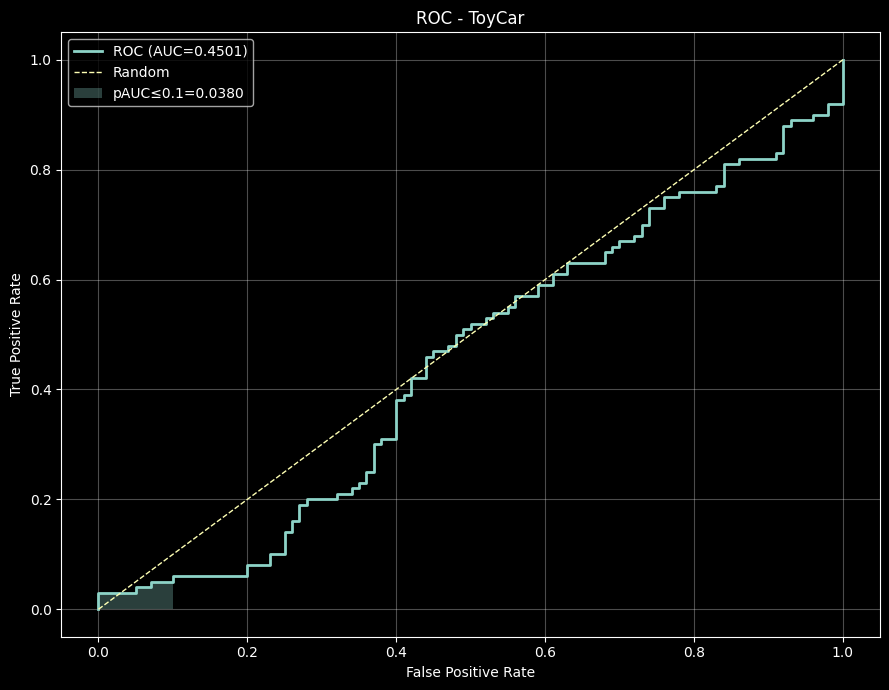

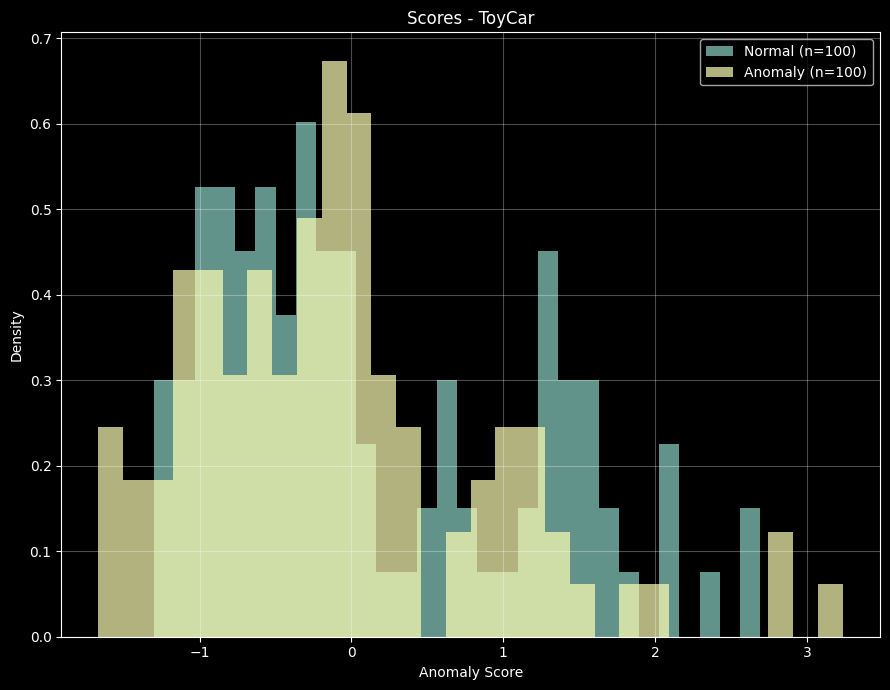

    ToyTrain | n= 200 | AUC=0.6273 | pAUC@0.1=0.0890


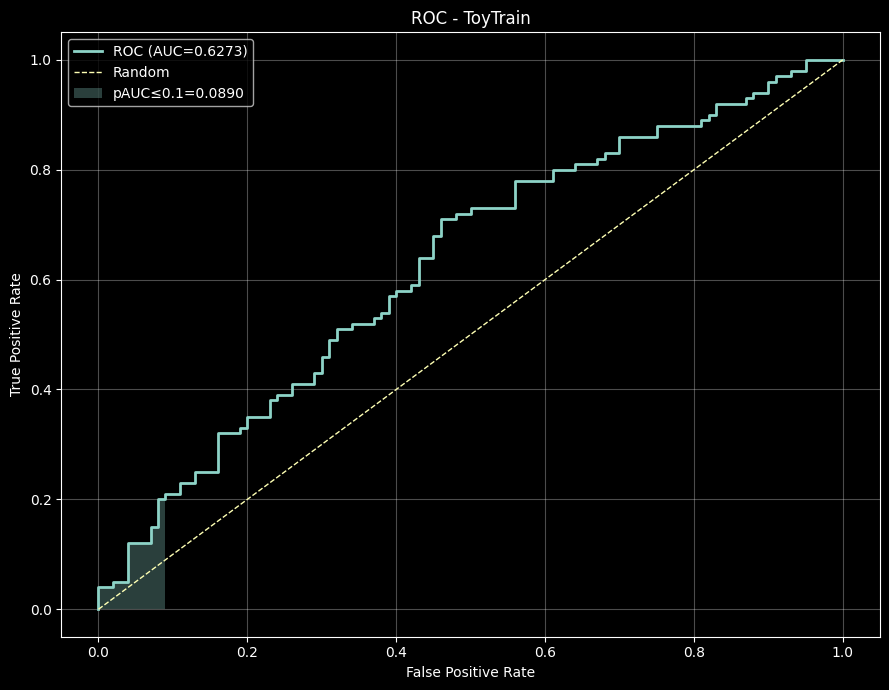

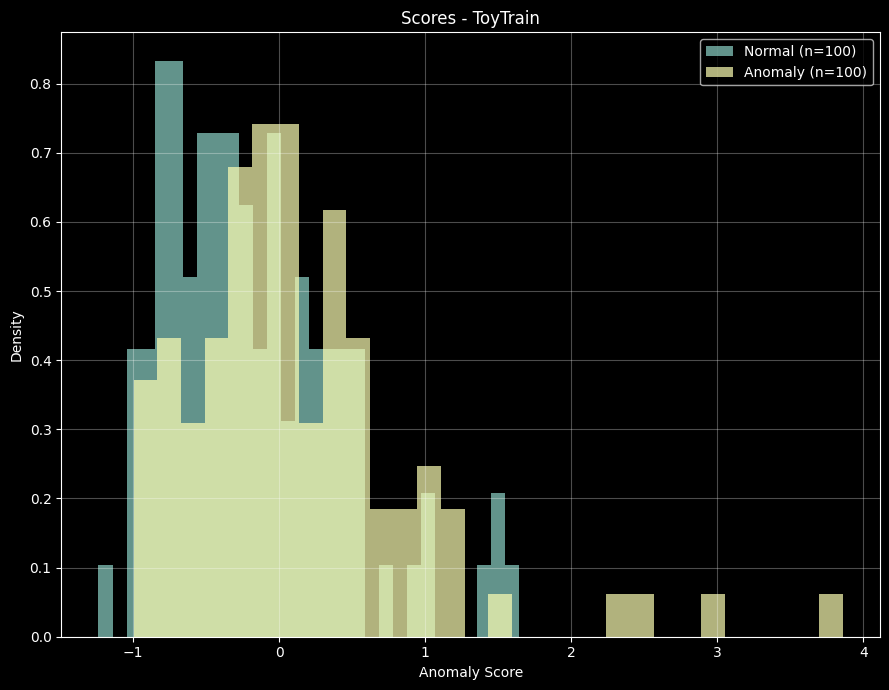

     bearing | n= 200 | AUC=0.6385 | pAUC@0.1=0.1500


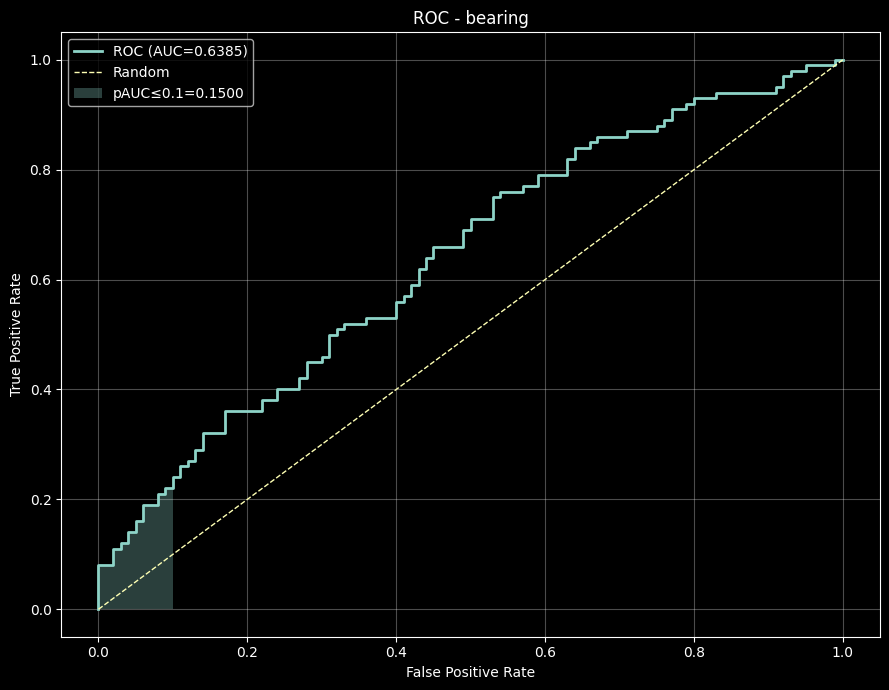

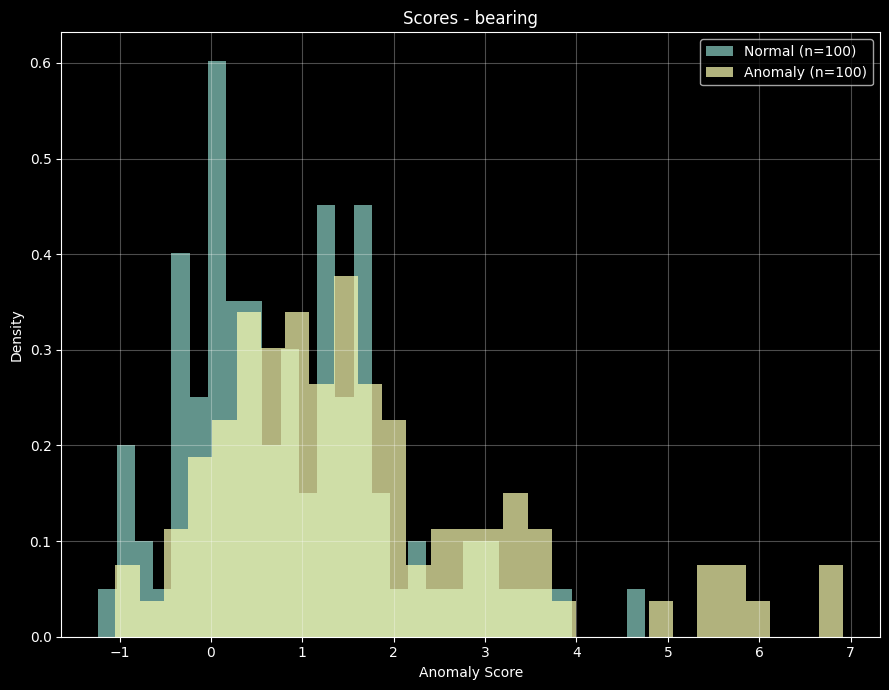

         fan | n= 200 | AUC=0.5790 | pAUC@0.1=0.0390


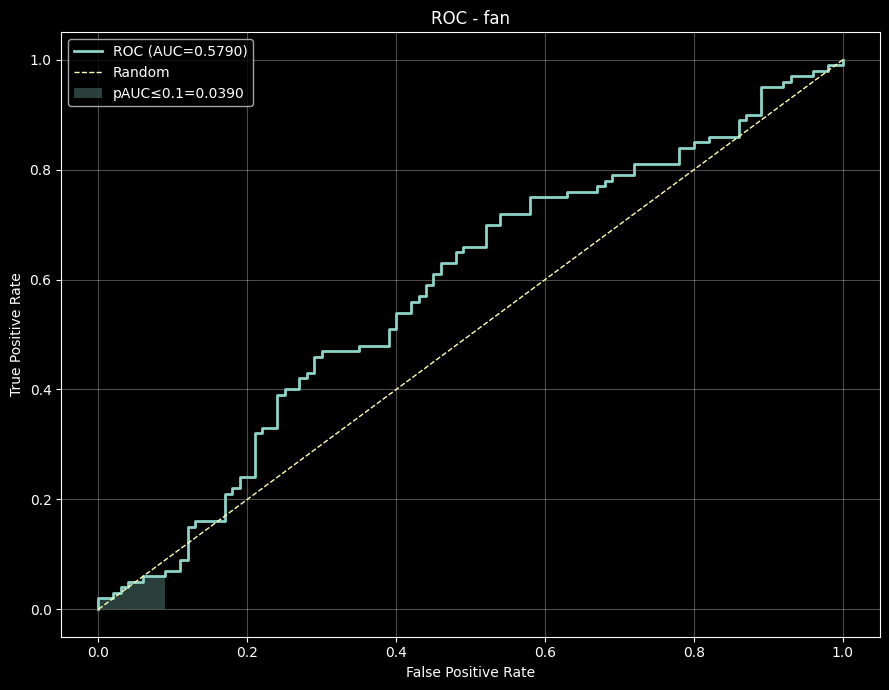

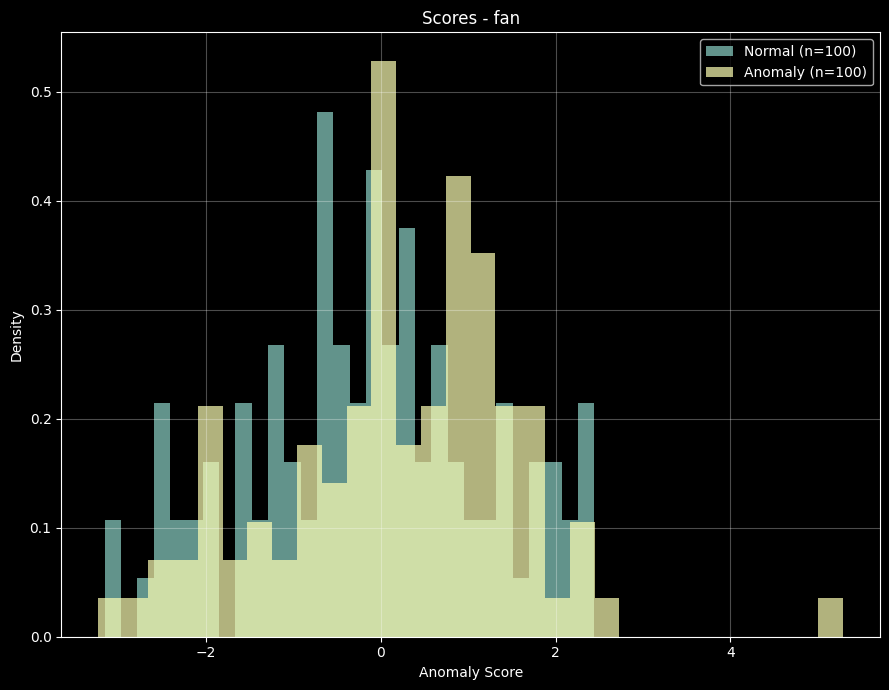

     gearbox | n= 200 | AUC=0.6348 | pAUC@0.1=0.0400


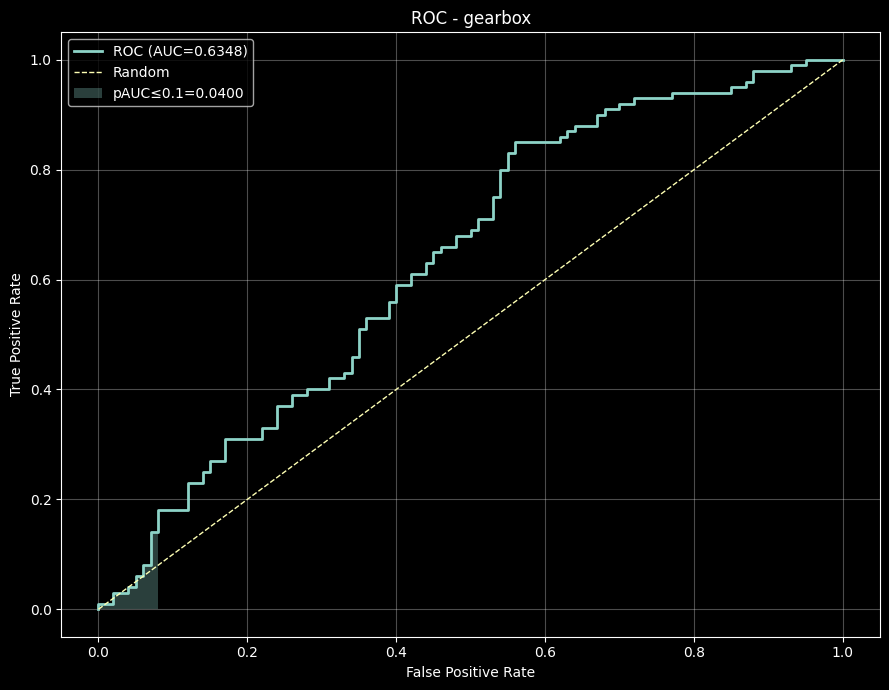

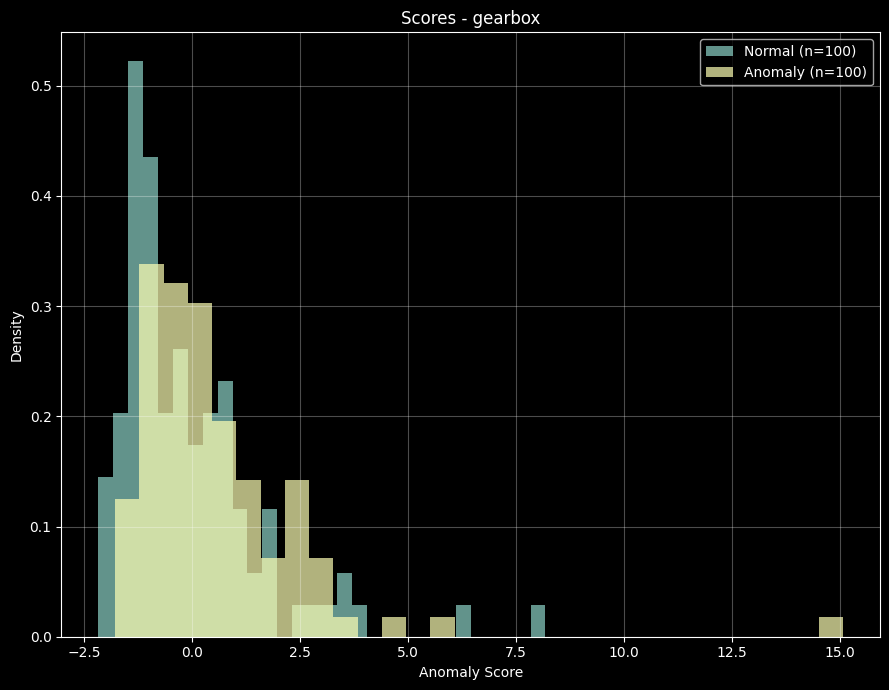

      slider | n= 200 | AUC=0.6364 | pAUC@0.1=0.1090


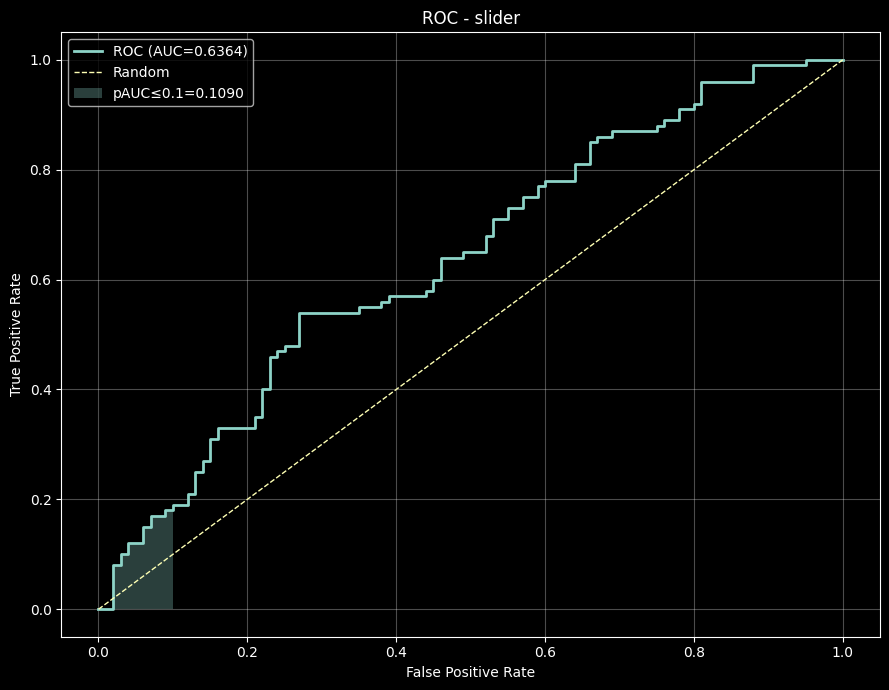

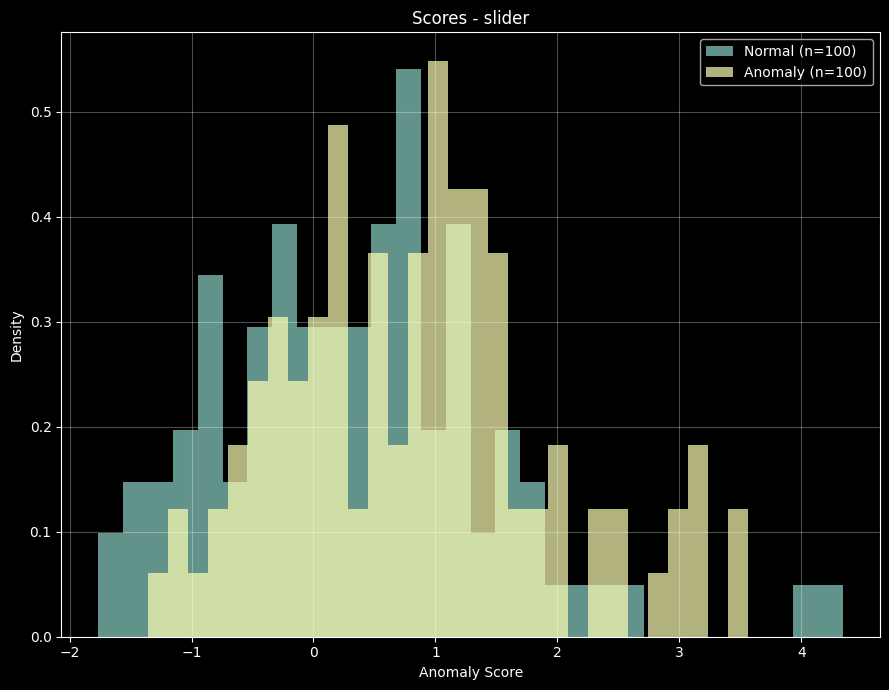

       valve | n= 200 | AUC=0.6771 | pAUC@0.1=0.1850


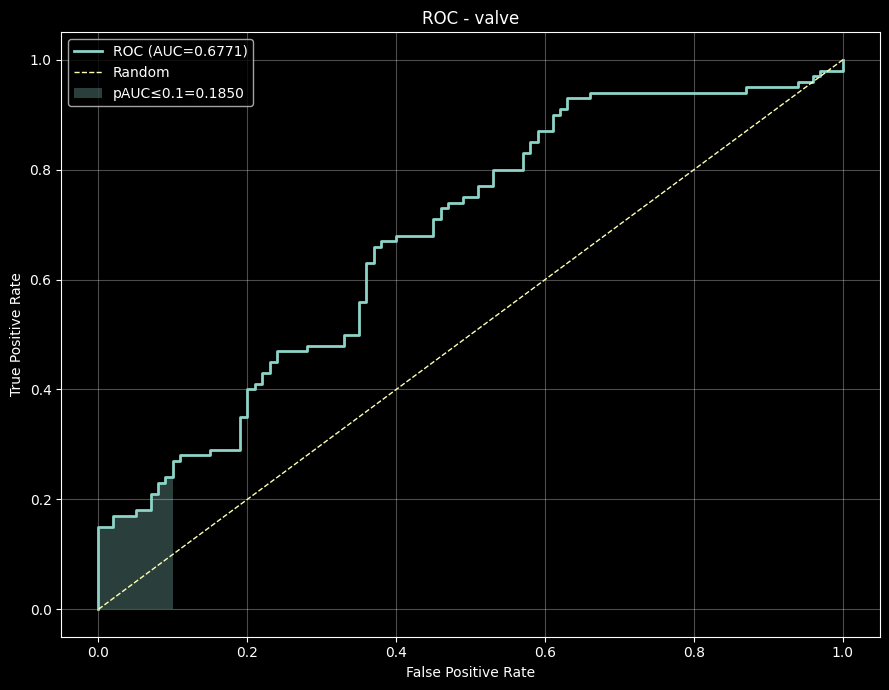

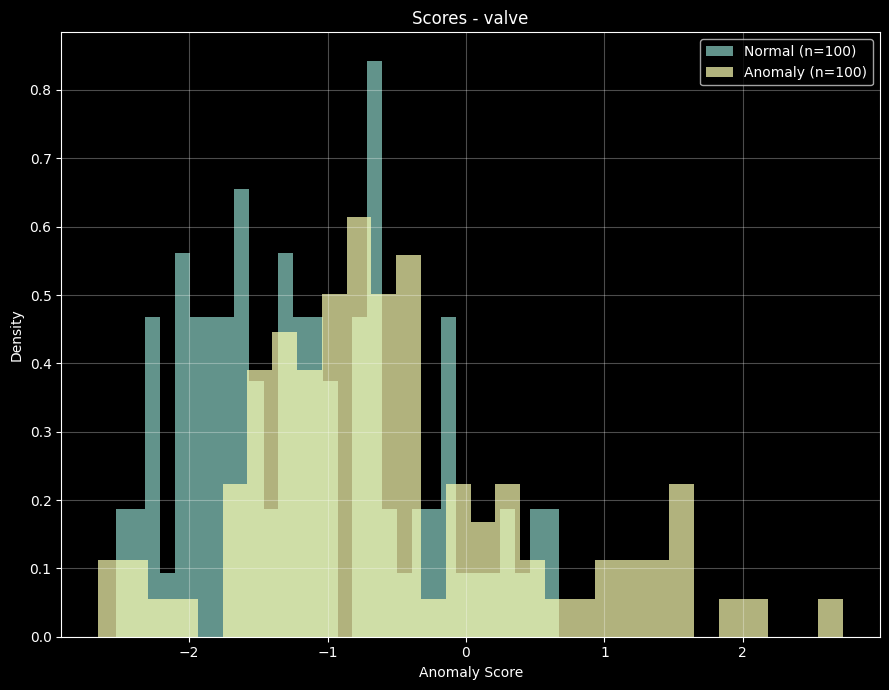

         ALL | n=1400 | AUC=0.5880 | pAUC@0.1=0.0901
[Metrics] Saved summary to results_attr_supervised/lora/metrics_summary.json


In [11]:
#@title 8) Metrics per machine (AUC & pAUC@0.1) + Plots
ensure_dir(RESULTS_DIR)
summary = {}

def compute_metrics(y_true, s):
    fpr, tpr, thr = roc_curve(y_true, s)
    roc_auc = auc(fpr, tpr)
    max_fpr = 0.1
    m = fpr <= max_fpr
    pauc = auc(fpr[m], tpr[m])/max_fpr if m.sum()>1 else 0.0
    return roc_auc, pauc, fpr, tpr

for m in sorted(set(machine_te)):
    mask = (machine_te == m)
    y_m = y_test[mask]
    s_m = scores[mask]
    auc_m, pauc_m, fpr, tpr = compute_metrics(y_m, s_m)
    print(f"{m:>12s} | n={len(y_m):4d} | AUC={auc_m:.4f} | pAUC@0.1={pauc_m:.4f}")
    summary[m] = {"n_test": int(len(y_m)), "auc": float(auc_m), "pauc_0.1": float(pauc_m)}
    matplotlib.use('inline')  # Ensure inline backend is used

    # ROC plot
    plt.figure()
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={auc_m:.4f})')
    plt.plot([0,1],[0,1],'--', linewidth=1, label='Random')
    msk = fpr <= 0.1
    plt.fill_between(fpr[msk], 0, tpr[msk], alpha=0.3, label=f'pAUC≤0.1={pauc_m:.4f}')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {m}")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.show()
    # plt.close()

    # Score histogram
    plt.figure()
    plt.hist(s_m[y_m==0], bins=30, alpha=0.7, density=True, label=f'Normal (n={(y_m==0).sum()})')
    plt.hist(s_m[y_m==1], bins=30, alpha=0.7, density=True, label=f'Anomaly (n={(y_m==1).sum()})')
    plt.xlabel("Anomaly Score"); plt.ylabel("Density"); plt.title(f"Scores - {m}")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.show()
    # plt.close()

# Overall metrics (all machines combined)
auc_all, pauc_all, fpr_all, tpr_all = compute_metrics(y_test, scores)
print(f"{'ALL':>12s} | n={len(y_test):4d} | AUC={auc_all:.4f} | pAUC@0.1={pauc_all:.4f}")
summary["__overall__"] = {"n_test": int(len(y_test)), "auc": float(auc_all), "pauc_0.1": float(pauc_all)}
summary["__meta__"] = {
    "model_id": CFG.model_id,
    "use_lora": bool(CFG.use_lora),
    "results_dir": str(RESULTS_DIR),
    "generated_at": datetime.now().isoformat(),
}
np.save(RESULTS_DIR/"scores_latest.npy", scores)
with open(RESULTS_DIR/"metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print(f"[Metrics] Saved summary to {RESULTS_DIR/'metrics_summary.json'}")

---
## Notes
- **PCA (fit on train)** stabilizes Mahalanobis; adjust `CFG.pca_var`.
- Energy uses the attribute head trained on cached train features; consider **temperature scaling** for calibration.
- If an attribute group is tiny, consider diagonal or tied covariance.
- Turn on **LoRA** (set `CFG.use_lora=True`) only if PEFT is installed.

In [12]:
#@title 1.6) EAT sanity probe: tokenization and pooling
# Take a small batch and inspect shapes and pooling behaviors.
probe_n = min(4, len(train_items))
probe_paths = [p for p, _, _ in train_items[:probe_n]]

# Build a temporary extractor honoring CFG.pool_mode
probe_extractor = build_feature_extractor(train_mode=False, pool_mode=CFG.pool_mode)
probe_extractor.model.eval()

# Prepare fbank batch like in datasets
fbs = []
lengths = []
mins = []
maxs = []
for p in probe_paths:
    w, sr0 = torchaudio.load(p)
    if w.shape[0] > 1:
        w = w.mean(dim=0, keepdim=True)
    if sr0 != CFG.sr:
        w = torchaudio.transforms.Resample(sr0, CFG.sr)(w)
    wt = w.squeeze(0)
    wt = wt - wt.mean()
    fb = torchaudio.compliance.kaldi.fbank(
        wt.unsqueeze(0), htk_compat=True, sample_frequency=CFG.sr,
        use_energy=False, window_type="hanning", num_mel_bins=128,
        dither=0.0, frame_shift=10,
    )
    T_true = fb.size(0)
    if CFG.target_length is not None:
        if T_true < CFG.target_length:
            fb = F.pad(fb, (0, 0, 0, CFG.target_length - T_true))
        elif T_true > CFG.target_length:
            fb = fb[: CFG.target_length, :]
    fb = (fb - NORM_MEAN) / (NORM_STD * CFG.norm_divisor)
    mins.append(float(fb.min()))
    maxs.append(float(fb.max()))
    fbs.append(fb)
    lengths.append(min(T_true, CFG.target_length or T_true))

x = torch.stack(fbs, dim=0)              # [B,T,128]
lengths_t = torch.tensor(lengths)
seq = probe_extractor._model_forward(x)   # [B,L,D]
B, L, D = seq.shape

# Expected tokens from patching: (T/16)*(128/16) + 1 extra token
expected_L = (CFG.target_length // 16) * (128 // 16) + 1
print(f"[EAT-Probe] seq shape: {seq.shape} | expected_L≈{expected_L}")
print(f"[EAT-Probe] fbank norm range per sample: min={min(mins):.3f}..{max(maxs):.3f}")

# Compare pooling variants on the same tokens
with torch.no_grad():
    # cls_only
    f_cls = seq[:, 0, :]
    # mean_no_cls
    f_mean_no_cls = probe_extractor._masked_mean(seq, lengths_t, drop_cls=True)
    # mean_with_cls
    f_mean_with_cls = probe_extractor._masked_mean(seq, lengths_t, drop_cls=False)

    def cos(a,b):
        return float(F.cosine_similarity(a.mean(0, keepdim=True), b.mean(0, keepdim=True)).item())

    print(f"[EAT-Probe] cos(cls, mean_no_cls)={cos(f_cls, f_mean_no_cls):.4f} | cos(cls, mean_with_cls)={cos(f_cls, f_mean_with_cls):.4f}")
    print(f"[EAT-Probe] ||cls||={f_cls.norm(dim=1).mean():.3f} | ||mean_no_cls||={f_mean_no_cls.norm(dim=1).mean():.3f} | ||mean_with_cls||={f_mean_with_cls.norm(dim=1).mean():.3f}")

[EAT-Probe] seq shape: torch.Size([4, 513, 768]) | expected_L≈513
[EAT-Probe] fbank norm range per sample: min=-1.278..0.800
[EAT-Probe] cos(cls, mean_no_cls)=0.1131 | cos(cls, mean_with_cls)=0.1135
[EAT-Probe] ||cls||=0.960 | ||mean_no_cls||=5.231 | ||mean_with_cls||=5.221


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issu

In [13]:
#@title 3.5) Train embedding quick diagnostics
# Basic checks: per-attribute counts and feature norms
with open(cache_train_meta) as f:
    _tm = json.load(f)
attr_labels = _tm.get("attrs", [])
vals, cnts = np.unique(attr_labels, return_counts=True)
print("[Diag] Num attributes:", len(vals))
print("[Diag] Smallest attribute group size:", int(cnts.min()) if len(cnts)>0 else 0)
print("[Diag] Largest attribute group size:", int(cnts.max()) if len(cnts)>0 else 0)
print("[Diag] Feature L2 mean norm:", float(np.linalg.norm(X_train, axis=1).mean()) if len(X_train)>0 else 0.0)

[Diag] Num attributes: 25
[Diag] Smallest attribute group size: 3
[Diag] Largest attribute group size: 1100
[Diag] Feature L2 mean norm: 0.7931300401687622


In [14]:
#@title 6.5) Gaussian conditioning diagnostics (per-attribute)
# Inspect condition numbers and sample counts per attribute in PCA space
from numpy.linalg import cond, eigvalsh

attrs_tr = np.array(train_meta["attrs"]) if isinstance(train_meta, dict) else np.array(json.load(open(cache_train_meta))["attrs"])  
attr_ids_tr = np.array([attr2id[a] for a in attrs_tr])
counts = {int(k): int(v) for k, v in zip(*np.unique(attr_ids_tr, return_counts=True))}

cond_rows = []
for aid, idxs in group_idx.items():
    Xi = Xtr_pca[idxs]
    if Xi.shape[0] >= 2:
        S = np.cov(Xi.T)
        c = float(cond(S + 1e-6*np.eye(S.shape[0])))
        ev_min = float(eigvalsh(S).min())
    else:
        c = float("inf"); ev_min = 0.0
    cond_rows.append({"attr_id": int(aid), "n": int(counts.get(int(aid), 0)), "cond(S)": c, "min_eig(S)": ev_min})

bad = [r for r in cond_rows if not np.isfinite(r["cond(S)"]) or r["cond(S)"]>1e6 or r["n"]<3]
print(f"[Diag] Attributes with potential ill-conditioning or low n: {len(bad)} / {len(cond_rows)}")
if bad:
    print("[Diag] Samples (first 10):", bad[:10])

[Diag] Attributes with potential ill-conditioning or low n: 9 / 25
[Diag] Samples (first 10): [{'attr_id': 0, 'n': 100, 'cond(S)': 67228732.87404807, 'min_eig(S)': -8.687292331965318e-16}, {'attr_id': 7, 'n': 5, 'cond(S)': 49434451.31952763, 'min_eig(S)': -9.323045034495732e-15}, {'attr_id': 8, 'n': 5, 'cond(S)': 190017202.35073406, 'min_eig(S)': -3.257986943042803e-14}, {'attr_id': 15, 'n': 3, 'cond(S)': 320573860.6492136, 'min_eig(S)': -1.280576467126742e-13}, {'attr_id': 16, 'n': 3, 'cond(S)': 236868795.7871908, 'min_eig(S)': -3.9113403719230194e-14}, {'attr_id': 17, 'n': 4, 'cond(S)': 425001184.2223129, 'min_eig(S)': -9.028128381678038e-14}, {'attr_id': 19, 'n': 100, 'cond(S)': 120900517.4773067, 'min_eig(S)': -8.639837481024872e-16}, {'attr_id': 22, 'n': 5, 'cond(S)': 99705665.93010098, 'min_eig(S)': -2.046335367622529e-14}, {'attr_id': 24, 'n': 5, 'cond(S)': 97983978.97999711, 'min_eig(S)': -2.3082286102275545e-14}]


In [15]:
#@title 7.5) Anomaly scoring variants: min vs. per-attribute vs. predicted-attribute
# 1) Existing min-over-all (already in `scores`)
auc_min, pauc_min, *_ = (auc_all, pauc_all, None, None) if 'auc_all' in globals() else (None, None, None, None)
print(f"[Scoring-Min] AUC={auc_min} pAUC@0.1={pauc_min}")

# 2) Oracle per-attribute (use true attribute from filename)
attr_te = np.array(test_meta["attrs"])
y_test = np.array(test_meta["y"], dtype=np.int64)

scores_attr = np.zeros(len(Xte_pca), dtype=np.float32)
for i in range(len(Xte_pca)):
    akey = attr_te[i]
    aid = attr2id.get(akey, None)
    if aid is None or aid not in mu:
        # fallback to min-over-all if missing
        ds = []
        for k in mu.keys():
            r = Xte_pca[i] - mu[k]
            ds.append(np.sqrt(np.dot(r, cov_inv[k] @ r)))
        scores_attr[i] = min(ds) if ds else 0.0
    else:
        r = Xte_pca[i] - mu[aid]
        scores_attr[i] = float(np.sqrt(np.dot(r, cov_inv[aid] @ r)))

# z-calibrate with same train stats as min version
z_attr = (scores_attr - maha_mu) / (maha_sd + 1e-9)
# Use existing helper compute_metrics (returns auc, pauc, fpr, tpr)
auc_attr, pauc_attr, fpr_attr, tpr_attr = compute_metrics(y_test, z_attr)
print(f"[Scoring-OracleAttr] AUC={auc_attr:.4f} pAUC@0.1={pauc_attr:.4f}")

# 3) Predicted-attribute (use attr head to pick group)
# Build inference logits (no margin for CosFace)
Xte_t = torch.from_numpy(X_test).to(device)
with torch.no_grad():
    if CFG.use_cosface:
        # reconstruct cosine logits without margin
        W = None
        for n, p in cls_head.named_parameters():
            if n.endswith('W'):
                W = p
                break
        if W is None:
            raise RuntimeError("CosFace head parameters not found for inference.")
        xn = F.normalize(Xte_t, dim=1)
        Wn = F.normalize(W, dim=0)
        logits_inf = CFG.cosface_s * (xn @ Wn)
    else:
        logits_inf = cls_head(Xte_t)
    pred_attr_ids = torch.argmax(logits_inf, dim=1).cpu().numpy()

scores_pred = np.zeros(len(Xte_pca), dtype=np.float32)
for i in range(len(Xte_pca)):
    aid = int(pred_attr_ids[i])
    if aid not in mu:
        ds = []
        for k in mu.keys():
            r = Xte_pca[i] - mu[k]
            ds.append(np.sqrt(np.dot(r, cov_inv[k] @ r)))
        scores_pred[i] = min(ds) if ds else 0.0
    else:
        r = Xte_pca[i] - mu[aid]
        scores_pred[i] = float(np.sqrt(np.dot(r, cov_inv[aid] @ r)))

z_pred = (scores_pred - maha_mu) / (maha_sd + 1e-9)
auc_pred, pauc_pred, fpr_pred, tpr_pred = compute_metrics(y_test, z_pred)
print(f"[Scoring-PredAttr]   AUC={auc_pred:.4f} pAUC@0.1={pauc_pred:.4f}")

[Scoring-Min] AUC=0.5879571428571428 pAUC@0.1=0.09014285714285714
[Scoring-OracleAttr] AUC=0.6177 pAUC@0.1=0.1003
[Scoring-PredAttr]   AUC=0.6391 pAUC@0.1=0.0941


# 7.6) Attribute classification diagnostics on TEST

This section evaluates how the attribute classifier assigns test recordings to classes.
It reports per-machine/overall accuracy, confusion matrices, and 2D PCA plots
(showing true vs predicted classes). A CSV with per-recording predictions is saved.

[Attr-CLS] Saved per-recording predictions to results_attr_supervised/lora/attr_predictions_test.csv
                                                path machine section  \
0  dataset_dev/ToyCar/test/section_00_source_test...  ToyCar   sec00   
1  dataset_dev/ToyCar/test/section_00_source_test...  ToyCar   sec00   
2  dataset_dev/ToyCar/test/section_00_source_test...  ToyCar   sec00   
3  dataset_dev/ToyCar/test/section_00_source_test...  ToyCar   sec00   
4  dataset_dev/ToyCar/test/section_00_source_test...  ToyCar   sec00   

   is_anomaly      true_attr  true_attr_id  pred_attr_id      pred_attr  \
0           1  ToyCar##sec00             1             1  ToyCar##sec00   
1           1  ToyCar##sec00             1             1  ToyCar##sec00   
2           1  ToyCar##sec00             1             1  ToyCar##sec00   
3           1  ToyCar##sec00             1             1  ToyCar##sec00   
4           1  ToyCar##sec00             1             1  ToyCar##sec00   

   correct  con

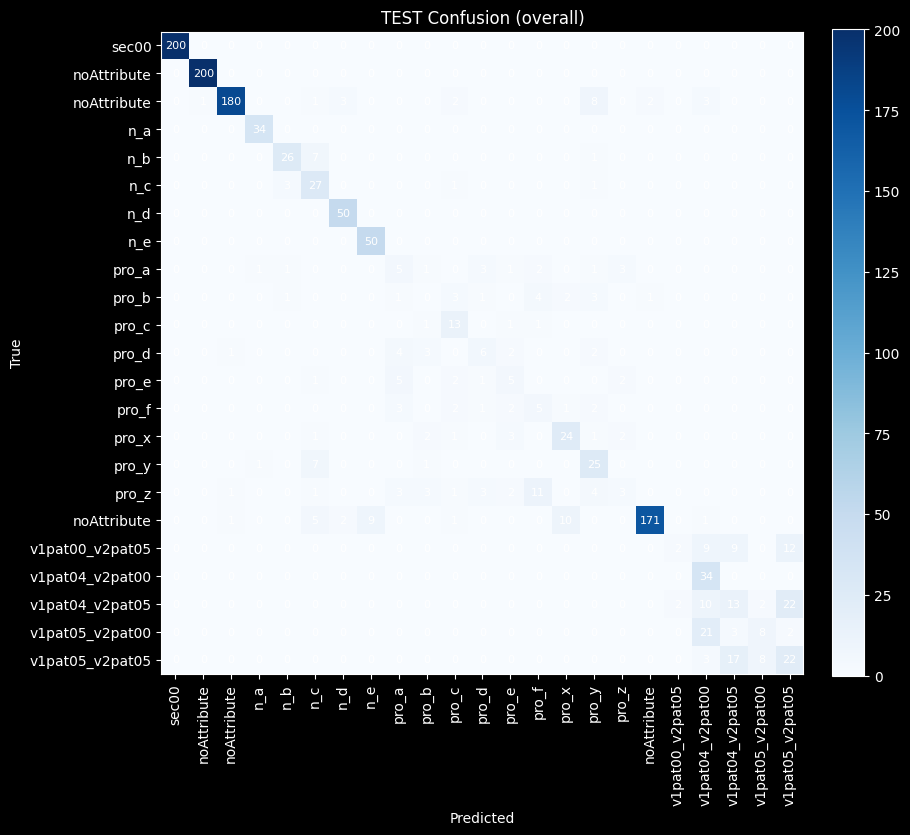

[Plot] Saved overall confusion to results_attr_supervised/lora/confusion_overall.png


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


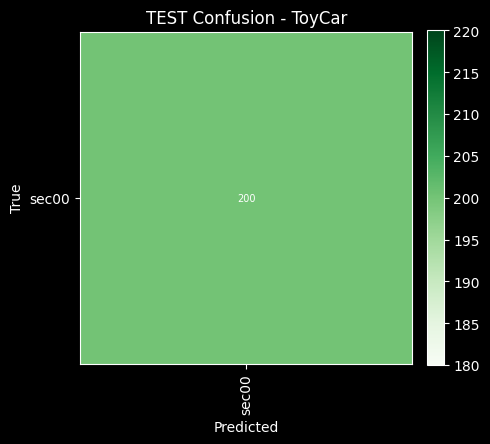

[Plot] Saved confusion for ToyCar to results_attr_supervised/lora/confusion_ToyCar.png


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


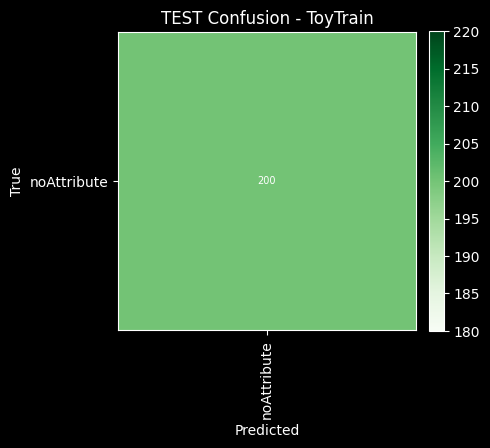

[Plot] Saved confusion for ToyTrain to results_attr_supervised/lora/confusion_ToyTrain.png


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


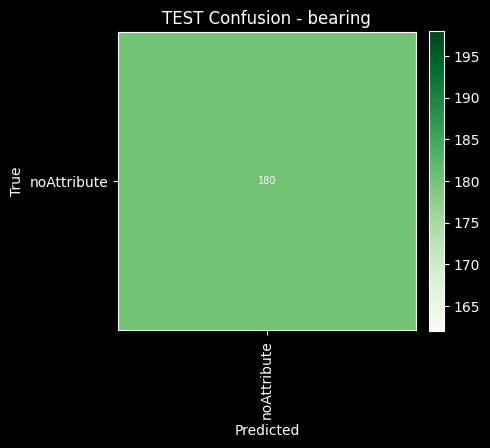

[Plot] Saved confusion for bearing to results_attr_supervised/lora/confusion_bearing.png


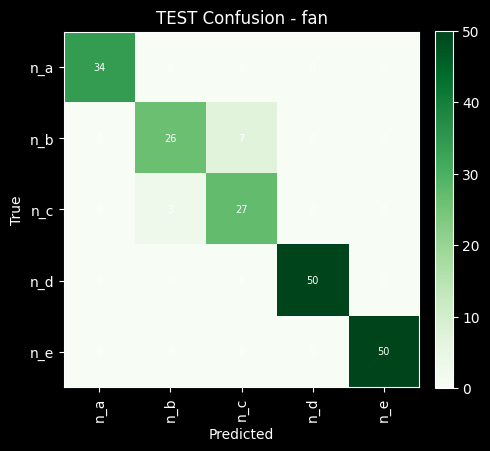

[Plot] Saved confusion for fan to results_attr_supervised/lora/confusion_fan.png


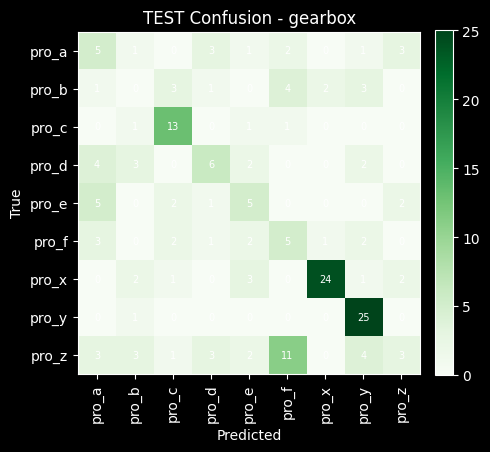

[Plot] Saved confusion for gearbox to results_attr_supervised/lora/confusion_gearbox.png


/home/sey87151/EAT_Clean/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


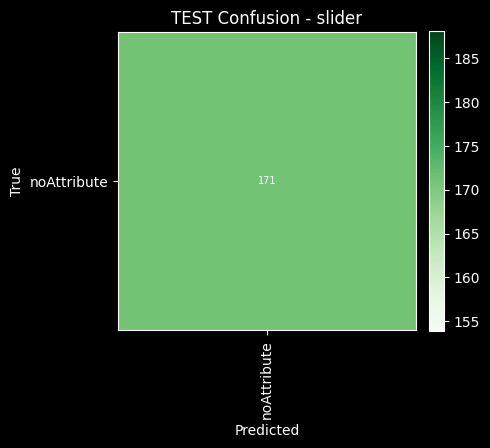

[Plot] Saved confusion for slider to results_attr_supervised/lora/confusion_slider.png


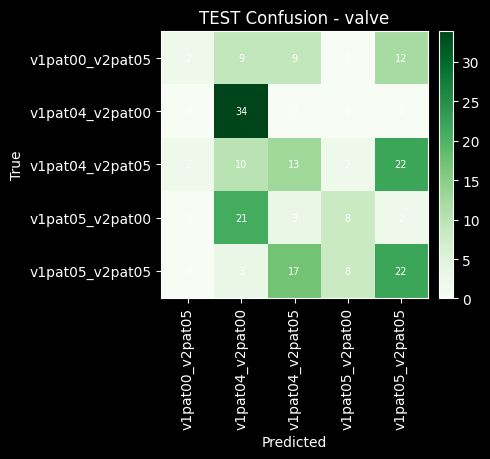

[Plot] Saved confusion for valve to results_attr_supervised/lora/confusion_valve.png


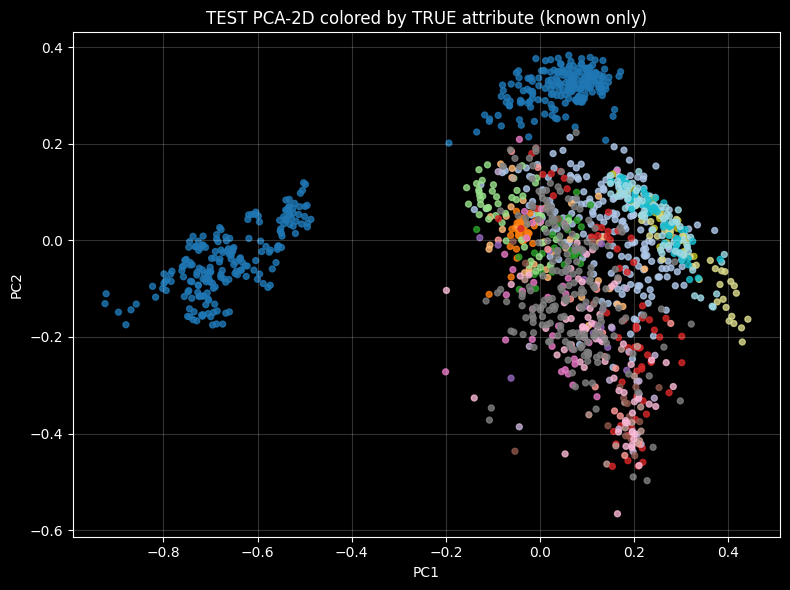

[Plot] Saved PCA-2D (true) to results_attr_supervised/lora/pca2d_true.png


<Figure size 900x700 with 0 Axes>

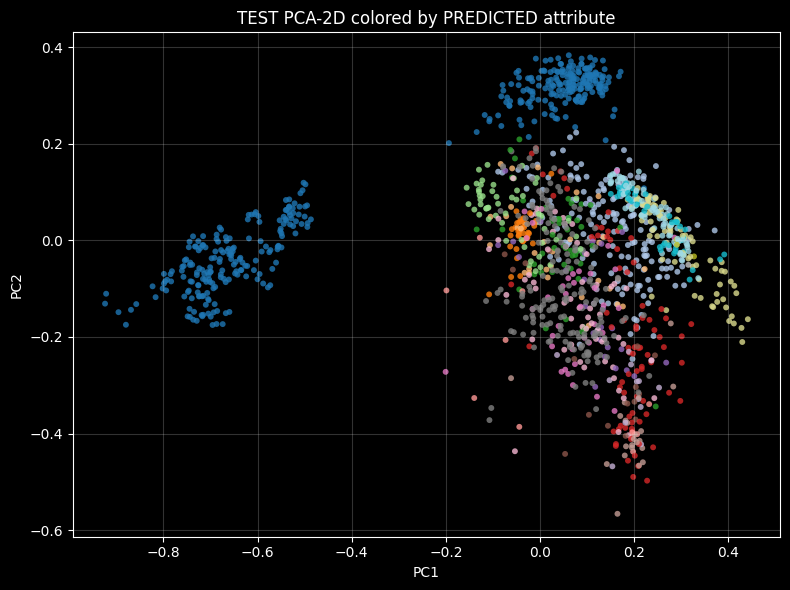

[Plot] Saved PCA-2D (pred) to results_attr_supervised/lora/pca2d_pred.png

[Report] ToyCar
               precision    recall  f1-score   support

ToyCar##sec00      1.000     1.000     1.000       200

     accuracy                          1.000       200
    macro avg      1.000     1.000     1.000       200
 weighted avg      1.000     1.000     1.000       200


[Report] ToyTrain
                       precision    recall  f1-score   support

ToyTrain##noAttribute      1.000     1.000     1.000       200

             accuracy                          1.000       200
            macro avg      1.000     1.000     1.000       200
         weighted avg      1.000     1.000     1.000       200


[Report] bearing
                      precision    recall  f1-score   support

bearing##noAttribute      1.000     0.900     0.947       200

           micro avg      1.000     0.900     0.947       200
           macro avg      1.000     0.900     0.947       200
        weighted avg      

<Figure size 900x700 with 0 Axes>

In [16]:
# Evaluate attribute classification on TEST and plot diagnostics
import numpy as np
import torch
import torch.nn.functional as F
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA as SKPCA
import matplotlib.pyplot as plt

ensure_dir(RESULTS_DIR)

# Ensure classifier head is available; if not, reload
try:
    cls_head
except NameError:
    d = X_train.shape[1]
    C = len(attr2id)
    if CFG.use_cosface:
        class CosFaceHead(nn.Module):
            def __init__(self, d, c, s=64.0, m=0.35):
                super().__init__()
                self.W = nn.Parameter(torch.randn(d, c))
                nn.init.xavier_uniform_(self.W)
                self.s = float(s); self.m = float(m)
            def forward(self, x, y):
                xn = F.normalize(x, dim=1)
                Wn = F.normalize(self.W, dim=0)
                cos = xn @ Wn
                onehot = F.one_hot(y, num_classes=cos.size(1)).float()
                cosm = cos - self.m * onehot
                return self.s * cosm
        cls_head = CosFaceHead(d, C, CFG.cosface_s, CFG.cosface_m).to(device)
    else:
        class LinearHead(nn.Module):
            def __init__(self, d, c): super().__init__(); self.fc = nn.Linear(d,c)
            def forward(self, x): return self.fc(x)
        cls_head = LinearHead(d, C).to(device)
    state = torch.load(RESULTS_DIR/"attr_head.pt", map_location=device)
    cls_head.load_state_dict(state); cls_head.eval()

# Build logits on TEST (CosFace without margin)
with torch.no_grad():
    Xte_t = torch.from_numpy(X_test).to(device)
    if CFG.use_cosface:
        W = None
        for n, p in cls_head.named_parameters():
            if n.endswith('W'):
                W = p
                break
        if W is None:
            raise RuntimeError("CosFace head parameters not found for inference.")
        xn_te = F.normalize(Xte_t, dim=1)
        Wn = F.normalize(W, dim=0)
        logits_te = CFG.cosface_s * (xn_te @ Wn)
    else:
        logits_te = cls_head(Xte_t)

probs_te = torch.softmax(logits_te, dim=1).cpu().numpy()
pred_ids = probs_te.argmax(axis=1)
conf_max = probs_te.max(axis=1)

# True attribute ids from filenames (may include unknowns)
attr_te = np.array(test_meta["attrs"])  # strings like machine##section
machine_te = np.array(test_meta["machines"])  # per-sample machine
section_te = np.array(test_meta["sections"])  # per-sample section
is_anom = np.array(test_meta["y"], dtype=np.int64)

true_ids = np.array([attr2id[a] if a in attr2id else -1 for a in attr_te], dtype=np.int64)
known_mask = true_ids >= 0

# Save per-recording predictions to CSV
import pandas as pd
rows = []
for i in range(len(X_test)):
    akey = attr_te[i]
    rows.append({
        "path": test_meta["paths"][i] if "paths" in test_meta else "",
        "machine": machine_te[i],
        "section": section_te[i],
        "is_anomaly": int(is_anom[i]),
        "true_attr": akey,
        "true_attr_id": int(true_ids[i]),
        "pred_attr_id": int(pred_ids[i]),
        "pred_attr": id2attr.get(int(pred_ids[i]), str(int(pred_ids[i]))),
        "correct": bool(known_mask[i] and (pred_ids[i] == true_ids[i])),
        "confidence": float(conf_max[i]),
    })
df_pred = pd.DataFrame(rows)
csv_path = RESULTS_DIR/"attr_predictions_test.csv"
df_pred.to_csv(csv_path, index=False)
print(f"[Attr-CLS] Saved per-recording predictions to {csv_path}")
print(df_pred.head())

# Overall accuracy (known-label subset) and normal-only accuracy
if known_mask.any():
    acc_all = accuracy_score(true_ids[known_mask], pred_ids[known_mask])
    acc_norm = accuracy_score(true_ids[known_mask & (is_anom==0)], pred_ids[known_mask & (is_anom==0)]) if (known_mask & (is_anom==0)).any() else float('nan')
    print(f"[Attr-CLS] TEST accuracy (all known): {acc_all:.4f} | normals-only: {acc_norm:.4f}")
else:
    print("[Attr-CLS] No known labels on TEST to score against.")

# Per-machine accuracies (known labels only)
for m in sorted(set(machine_te)):
    mask_m = (machine_te == m) & known_mask
    if mask_m.sum() == 0:
        continue
    acc_m = accuracy_score(true_ids[mask_m], pred_ids[mask_m])
    acc_m_norm = accuracy_score(true_ids[mask_m & (is_anom==0)], pred_ids[mask_m & (is_anom==0)]) if (mask_m & (is_anom==0)).any() else float('nan')
    print(f"{m:>12s} | n={int(mask_m.sum()):4d} | acc={acc_m:.4f} | acc(normals)={acc_m_norm:.4f}")

# Confusion matrices
label_ids_present = sorted(set(true_ids[known_mask].tolist()))
label_names = [id2attr[i] for i in label_ids_present]
short_names = [n.split('##')[1] if '##' in n else n for n in label_names]

# Overall confusion (only if not too many classes)
if len(label_ids_present) > 0 and len(label_ids_present) <= 30:
    cm = confusion_matrix(true_ids[known_mask], pred_ids[known_mask], labels=label_ids_present)
    fig, ax = plt.subplots(figsize=(max(6, 0.4*len(label_ids_present)), max(5, 0.4*len(label_ids_present))))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title('TEST Confusion (overall)')
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_xticks(range(len(short_names))); ax.set_xticklabels(short_names, rotation=90)
    ax.set_yticks(range(len(short_names))); ax.set_yticklabels(short_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(int(cm[i, j])), va='center', ha='center', fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    fig_path = RESULTS_DIR/"confusion_overall.png"
    fig.savefig(fig_path, dpi=150)
    print(f"[Plot] Saved overall confusion to {fig_path}")
else:
    print("[Plot] Skipping overall confusion (too many classes). See per-machine below.")

# Per-machine confusion (restricted label sets)
for m in sorted(set(machine_te)):
    mask_m = (machine_te == m) & known_mask
    if mask_m.sum() == 0:
        continue
    labels_m = sorted(set(true_ids[mask_m].tolist()))
    names_m = [id2attr[i] for i in labels_m]
    short_m = [n.split('##')[1] if '##' in n else n for n in names_m]
    cm_m = confusion_matrix(true_ids[mask_m], pred_ids[mask_m], labels=labels_m)
    fig, ax = plt.subplots(figsize=(max(5, 0.4*len(labels_m)), max(5, 0.4*len(labels_m))))
    im = ax.imshow(cm_m, cmap='Greens')
    ax.set_title(f'TEST Confusion - {m}')
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_xticks(range(len(short_m))); ax.set_xticklabels(short_m, rotation=90)
    ax.set_yticks(range(len(short_m))); ax.set_yticklabels(short_m)
    for i in range(cm_m.shape[0]):
        for j in range(cm_m.shape[1]):
            ax.text(j, i, str(int(cm_m[i, j])), va='center', ha='center', fontsize=7)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    fig_path = RESULTS_DIR/f"confusion_{m}.png"
    fig.savefig(fig_path, dpi=150)
    print(f"[Plot] Saved confusion for {m} to {fig_path}")

# 2D PCA visualization (overall)
pca2 = SKPCA(n_components=2, random_state=CFG.seed)
X2 = pca2.fit_transform(X_test)

# Plot true classes (known only)
if known_mask.any():
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X2[known_mask,0], X2[known_mask,1], c=true_ids[known_mask], cmap='tab20', s=18, alpha=0.8)
    plt.title('TEST PCA-2D colored by TRUE attribute (known only)')
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.grid(True, alpha=0.2); plt.tight_layout(); plt.show()
    plt.savefig(RESULTS_DIR/"pca2d_true.png", dpi=150)
    print(f"[Plot] Saved PCA-2D (true) to {RESULTS_DIR/'pca2d_true.png'}")

# Plot predicted classes (all)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2[:,0], X2[:,1], c=pred_ids, cmap='tab20', s=18, alpha=0.8, edgecolors='none')
plt.title('TEST PCA-2D colored by PREDICTED attribute')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.grid(True, alpha=0.2); plt.tight_layout(); plt.show()
plt.savefig(RESULTS_DIR/"pca2d_pred.png", dpi=150)
print(f"[Plot] Saved PCA-2D (pred) to {RESULTS_DIR/'pca2d_pred.png'}")

# Classification report (numbers) per machine (known only)
for m in sorted(set(machine_te)):
    mask_m = (machine_te == m) & known_mask
    if mask_m.sum() == 0:
        continue
    labels_m = sorted(set(true_ids[mask_m].tolist()))
    report = classification_report(true_ids[mask_m], pred_ids[mask_m], labels=labels_m, target_names=[id2attr[i] for i in labels_m], digits=3)
    print(f"\n[Report] {m}\n" + report)


In [17]:
#@title 9) Debug summary snapshot
from pprint import pprint
if DEBUG_PATH.exists():
    with open(DEBUG_PATH) as f:
        debug_snapshot = json.load(f)
    print("[Debug] Keys recorded:", list(debug_snapshot.keys()))
    attr_test_dbg = debug_snapshot.get("attr_head_test", {}).get("data", {})
    anomaly_dbg = debug_snapshot.get("anomaly_scores", {}).get("data", {})
    low_machine_cls = {k: v for k, v in attr_test_dbg.get("machine_accuracy", {}).items() if v < 0.7}
    low_attr_cls = {k: v for k, v in attr_test_dbg.get("per_attr_accuracy", {}).items() if v < 0.7}
    if low_machine_cls:
        print("[Debug] Machines with weak classification accuracy (<0.70):")
        pprint(low_machine_cls)
    if low_attr_cls:
        print("[Debug] Attributes with weak classification accuracy (<0.70):")
        pprint(low_attr_cls)
    if anomaly_dbg:
        score_profiles = anomaly_dbg.get("scores_by_machine", {})
        weak_scores = {
            k: v for k, v in score_profiles.items()
            if isinstance(v, dict) and v.get("anomaly_mean", 0.0) <= v.get("normal_mean", 0.0)
        }
        if weak_scores:
            print("[Debug] Machines with overlapping score means (anomaly ≤ normal):")
            pprint(weak_scores)
    metrics_path = RESULTS_DIR / "metrics_summary.json"
    if metrics_path.exists():
        with open(metrics_path) as f:
            metrics_summary = json.load(f)
        print("[Debug] Overall metrics summary excerpt:")
        pprint(metrics_summary.get("__overall__", {}))
        per_machine = {
            k: v for k, v in metrics_summary.items()
            if k not in {"__overall__", "__meta__"}
        }
        if per_machine:
            ranked = {
                k: {"auc": v.get("auc"), "pauc_0.1": v.get("pauc_0.1")}
                for k, v in per_machine.items()
            }
            print("[Debug] Per-machine metrics:")
            pprint(ranked)
else:
    print("[Debug] No debug trace found yet at", DEBUG_PATH)

[Debug] Keys recorded: ['lora', 'features_train', 'attr_sampler', 'attr_head_train', 'features_test', 'attr_head_test']
[Debug] Machines with weak classification accuracy (<0.70):
{'gearbox': 0.43, 'valve': 0.395}
[Debug] Attributes with weak classification accuracy (<0.70):
{'ToyCar##noAttribute': 0.0,
 'gearbox##pro_a': 0.2777777777777778,
 'gearbox##pro_b': 0.0,
 'gearbox##pro_d': 0.3333333333333333,
 'gearbox##pro_e': 0.3125,
 'gearbox##pro_f': 0.3125,
 'gearbox##pro_z': 0.09375,
 'valve##noAttribute': 0.0,
 'valve##v1pat00_v2pat05': 0.0625,
 'valve##v1pat04_v2pat05': 0.26,
 'valve##v1pat05_v2pat00': 0.23529411764705882,
 'valve##v1pat05_v2pat05': 0.44}
[Debug] Overall metrics summary excerpt:
{'auc': 0.5879571428571428, 'n_test': 1400, 'pauc_0.1': 0.09014285714285714}
[Debug] Per-machine metrics:
{'ToyCar': {'auc': 0.4501, 'pauc_0.1': 0.038},
 'ToyTrain': {'auc': 0.6273000000000001, 'pauc_0.1': 0.08899999999999998},
 'bearing': {'auc': 0.6385000000000002, 'pauc_0.1': 0.15},
 'fan'